In [ ]:
# ------------------------------
import pandas as pd
import numpy as np
from scipy.optimize import minimize
# ------------------------------
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve
# ------------------------------
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# ------------------------------
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score,  roc_auc_score, confusion_matrix, roc_curve, auc, r2_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Binarizer
from sklearn.datasets import make_classification, make_regression
import optuna
# ------------------------------
import time
import warnings
warnings.filterwarnings('ignore')

# Тема курсовой работы: Байесовская оптимизация для настройки гипперапараметров моделей машинного обучения.

# Задача: применение на практике байесовской оптимизации для настройки гипперпараметров моделей машиннного обучения.

Перед выполнением поставленной задачи необходимо определить решаемую задачу машинного обучения и данные её характеризующие.

В качетсве решаемой задачи машинного обучения выбрана задача кредитного скорринга, то есть классификация клиента как "вернёт кредит" или "не вернёт кредит" по некторому набору признаков. Данные взяты с сайта [kaggle](https://www.kaggle.com/competitions/GiveMeSomeCredit/overview).

# Байесовская оптимизация

## Введение

- [Black-Box Optimization Challenge, или как подбирать гиперпараметры для моделей](https://habr.com/ru/companies/hsespb/articles/537020/) (Дата обращения 29.03.2025)

В задачах машинного обучения и прикладной математики часто возникает необходимость оптимизировать (минимизировать или максимизировать) некоторую **черную коробку** — функцию, аналитически не заданную, дорогую по вычислениям, с шумами или без градиента. Пример: подбор гиперпараметров моделей, оптимизация поведения агентов в Reinforcement Learning.

Классическая оптимизация (градиентный спуск, метод Ньютона и т.п.) здесь неприменима. Поэтому используют методы глобальной оптимизации без производных, такие как:
- Случайный поиск
- Эволюционные алгоритмы
- Байесовская оптимизация

Байесовская оптимизация — это пошаговый вероятностный метод, который строит аппроксимацию целевой функции с помощью **Гауссовского процесса**, а затем использует **функцию приобретения**, чтобы решить, где смотреть дальше.

## Гауссовский процесс

- [Регрессия гауссовского процесса с самого начала](https://habr.com/ru/companies/skillfactory/articles/562892/) (Дата обращения 29.03.2025)
- [\[DeepBayes\] День 4, лекция 2. Гауссовские процессы и байесовская оптимизация](https://youtu.be/PgJMLpIfIc8?si=Xkxg0Ndqox6NNqUp) (Дата обращения 29.03.2025)

Гауссовский процесс (ГП) — это обобщение многомерного нормального распределения на бесконечномерные пространства функций. Мы предполагаем, что значения функции в любой конечной выборке точек распределены многомерно-нормально.

Дано:
$$
\begin{align}
    & \mathbf{X} = \{x_1, ..., x_n\} \\
    & \mathbf{f} = \{f_{1}(x_1), ..., f_{n}(x_n)\} = \mathbf{y} = \{y_1, ..., y_n\} \\
\end{align}
$$

Обучение:
$$
\begin{align}
    & p(\mathbf{f}|\mathbf{X}) = \mathcal{N}(\mu, \mathbf{K}) \\
    & f(\mathbf{x}) \sim \mathcal{GP}(\mu(\mathbf{x}), k(\mathbf{x}, \mathbf{x}^{\prime})) \\
    & \mu(\mathbf{x}) = \mathbb{E}(f(\mathbf{x})) \\
    & k(\mathbf{x}, \mathbf{x}^{\prime}) = \mathbb{E}(f(\mathbf{x} - m(\mathbf{x}))f(\mathbf{x}^{\prime} - m(\mathbf{x}^{\prime}))) = cov(\mathbf{x}, \mathbf{x}^{\prime})=\sigma_{f}^{2}\exp\{-\sum_{i=1}^{d}\frac{(x_{i}-x_{i}^{\prime})^2}{2r_{i}^2}\}\text{ - rbf kernel}
\end{align}
$$

Предсказание:
$$
\begin{align}
    & y_* = f_{*}(\mathbf{x}_{*}) + \epsilon_{*} \\
    & p(\mathbf{y}, f_{*}) = \mathcal{N}\left(0, \left[ \begin{matrix} 
        \mathbf{K} + \sigma^2 I_m & \mathbf{k}_* \\ 
        \mathbf{k}_*^{\top} & \mathbf{K}_{**} 
    \end{matrix} \right]\right) \\
    & \mu_\ast = \mathbf{k}_\ast^\mathrm{T} [\mathbf{K} + \sigma^2 \mathbf{I}_m]^{-1} \mathbf{y}, \\
    & \sigma_\ast^2 = \bar{K}_{\ast\ast} - \mathbf{k}_\ast^\mathrm{T} [\mathbf{K} + \sigma^2 \mathbf{I}_m]^{-1} \mathbf{k}_\ast

\end{align}
$$

## Проклятье размерности

- [Коэффициент вариации](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%B8) (Дата обращения 30.03.2025)
- [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) (Дата обращения 30.03.2025)

При увеличении количества признаков точность предсказаний гауссовского процесса падет (это можно корректировать подбором коэффициента $r$, но не существенно). **Причина - проклятье размерности**. При увеличении признаков расстояние между объектами становится всё более одинаковым и, как следствие, rbf-ядро перестаёт работать. 

Рассмотрим вычисление евклидового расстояния $D^2=||x_i - x_j||^2 = \sum_{i,j=1}^d (x_i - x_j)^2$ между независимыми равномерно распределнными точками в d-мерном единичном кубе $[0, 1]^d$:
$$
\begin{align}
    & \mathbb{E}(D^2) = d\mathbb{E}((x_i - x_j)^2) = \frac{d}{6} \\
    & Var(D^2) = d Var((x_i - x_j)^2) = d (\mathbb{E}[(x_i - x_j)^4] - \mathbb{E}[(x_i - x_j)^2]^2) = \frac{d}{45} \\
    & CV = \frac{\sigma}{\mu} = \frac{6\sqrt{\frac{d}{45}}}{d} \rightarrow \lim_{d \rightarrow \infty}CV = 0
\end{align}
$$
Видно, что $CV$ (коэффициент вариации, показывающий изменчивость данных в выборке) стремится к 0 при увеличении размерности, то есть, действительно, евклидово расстояние для всех точек становится практически одинаковым. 

In [289]:
class GaussianProcess:
    def __init__(self, sigma=1, r=1, noise=0.1):
        self.sigma = sigma # Предполагаемое распределение
        self.r = r # Данный параметр масштабирует значения ковариационной функции
        self.noise = noise # Ввожу шум для борьбы с вырожденными ковариационными матрицами 

    def rbf_kernel(self, xi, xj, sigma=1.0, r=1.0):
        return sigma**2 * np.exp( -np.sum( (xi - xj)**2 / (2 * r**2) ) ) # Абсолютно гладкое гауссовское ядро
    
    def cov(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        return np.array(
            [self.rbf_kernel(x1, x2, self.sigma, self.r) for x1 in X1 for x2 in X2]
        ).reshape( (len(X1), len(X2)) )
    
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train) 
        return self

    def predict(self, X_test):
        X_test = np.array(X_test)
        K = self.cov(self.X_train) # Считаем ковариационные матрицы трейна с самим собой
        K_ss = self.cov(X_test) # Считаем ковариационные матрицы теста с самим собой
        K_s = self.cov(self.X_train, X_test) # Считаем ковариационные матрицы трейна и тестом
        K_inv = np.linalg.inv(K + self.noise**2 * np.eye(len(self.X_train))) # Обратная матрица с регуляризационным членом
        mu_s = K_s.T @ K_inv @ self.y_train # Предсказываем среднее
        cov_s = K_ss - K_s.T @ K_inv @ K_s # Предсказываем дисперсии
        return (mu_s, np.diag(cov_s))

In [290]:
X_GP, y_GP = make_regression(n_features=1)
X_train_GP, X_test_GP, y_train_GP, y_test_GP = train_test_split(X_GP, y_GP, test_size=0.1)

model_GP = GaussianProcess().fit(X_train_GP, y_train_GP)
mu, var = model_GP.predict(X_test_GP)

r2_score(y_test_GP, mu)

0.99985988320731

## Функция приобретения

- [Acquisition functions in Bayesian Optimization](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html) (Дата обращения 30.03.2025)

Функция приобретения — это стратегия, которая говорит нам, где в пространстве искать следующую точку. Она использует аппроксимацию целевой функции (полученную с помощью ГП) и балансирует **эксплуатацию** (исследование известных хороших областей) и **исследование** (поиск новых, потенциально хороших областей).

Есть следующие варианты:
- **Expected Improvement (EI)** – ожидаемое улучшение над текущим максимумом.
$$
\begin{align}
    & \mathrm{EI}(x;\xi) = (\mu - f(x^*) - \xi)\,\Phi\left(\frac{\mu - f(x^*) - \xi}{\sigma}\right) + \sigma\,\varphi\left(\frac{\mu - f(x^*) - \xi}{\sigma}\right) \\
    & \Phi(x) - \mathrm{CDF}(x),\space \varphi(x) = \frac{1}{\sqrt{2\pi}}\exp(\frac{-x^2}{2})
\end{align}
$$
- **Probability of Improvement (PI)** – вероятность улучшения.
$$
\begin{align}
& \mathrm{PI}(x)=\Phi(\frac{\mu(x) - f(x^{*})}{\sigma(x)})
\end{align}
$$
- **Upper Confidence Bound (UCB)** – линейная комбинация предсказания и его дисперсии.
$$
\begin{align}
& \mathrm{UCB}(x) = \mu(x) + \beta\sigma(x)
\end{align} 
$$

Выбор функции зависит от задачи и чувствительности к шуму.

In [293]:
class AcquisitionFunc:
    def UCB(self, model_gp, x, b = 1):
        x = np.array([x])
        m, var = model_gp.predict(x)
        return -1*(m + b * var)

## Порядок работы алгоритма оптимизации:
1. Получение начальных значений оптимизируемой функции
2. Обучение на них гауссовского процесса
3. Максимизация (минимизация отрицательного значения) функции приобретения
4. Получение значения целевой функции в точке, полученной на предыдущем шаге
5. Переобучение гауссового процесса с учетом новой информации: точки максимизирующей функцию приобретения и значения на ней целевой функции

In [ ]:
from sklearn.base import clone

class GaussianProcess:
    def __init__(self, sigma=1, r=1, noise=0.1):
        self.sigma = sigma # Предполагаемое распределение
        self.r = r # Данный параметр масштабирует значения ковариационной функции
        self.noise = noise # Ввожу шум для борьбы с вырожденными ковариационными матрицами 

    def rbf_kernel(self, xi, xj, sigma=1.0, r=1.0):
        return sigma**2 * np.exp( -np.sum( (xi - xj)**2) / (2 * r**2) ) # Абсолютно гладкое гауссовское ядро
    
    def cov(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        return np.array(
            [self.rbf_kernel(x1, x2, self.sigma, self.r) for x1 in X1 for x2 in X2]
        ).reshape( (len(X1), len(X2)) )
    
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train) 
        return self

    def predict(self, X_test):
        X_test = np.array(X_test)
        K = self.cov(self.X_train) # Считаем ковариационные матрицы трейна с самим собой
        K_ss = self.cov(X_test) # Считаем ковариационные матрицы теста с самим собой
        K_s = self.cov(self.X_train, X_test) # Считаем ковариационные матрицы трейна и тестом
        K_inv = np.linalg.inv(K + self.noise**2 * np.eye(len(self.X_train))) # Обратная матрица с регуляризационным членом
        mu_s = K_s.T @ K_inv @ self.y_train # Предсказываем среднее
        cov_s = K_ss - K_s.T @ K_inv @ K_s # Предсказываем дисперсии
        return (mu_s, np.diag(cov_s))

class AcquisitionFunc:
    def UCB(self, model_gp, X, b = 2):
        m, var = model_gp.predict(X.reshape(1, -1))
        return -1*(m + b * var)

class BayesOptimization:
    def __init__(self, model,
                       dict_params,
                       scoring,
                       obj_func="GP",
                       acq_func="UCB",
                       n_iters=50,
                       cv=5):
        
        self.n_iters = n_iters
        self.cv = cv
        self.scoring = scoring
        self.obj_func = obj_func
        self.acq_func = acq_func  
        self.model = model
        self.dict_params = dict_params

    def fit(self, X, y):
        number_of_starting_points = 10
        X_sample, Y_sample = [], []
        for point in range(number_of_starting_points): 
            # Задаём каким образом генерирутся оптимизируемые параметры для модели
            uniform_func = np.random.uniform
            # Здесь хранятся случайные значения для оптимизируемых параметров
            optimization_params = {}
            nums_for_params = []
            for key, param in self.dict_params.items(): 
                # Тип переменной
                type_func = param[0]
                # Интервал
                a, b = param[1]
                # Генерация значения гиперпараметра
                num = type_func(uniform_func(a, b))
                optimization_params[key] = num
                nums_for_params.append(num)
            # Кросс-валидация с сгенерированными параметрами 
            model = clone(self.model).set_params(**optimization_params)
            cv_results = cross_validate(model.set_params(**optimization_params),
                                        X, y)
            # Запоминаем новую стартовую точку
            X_sample.append(nums_for_params)
            Y_sample.append(np.mean(cv_results["test_score"]))
        # Перевожу в np массив
        X_sample = np.array(X_sample)
        Y_sample = np.array(Y_sample)
        # Обучение гауссовского процесса
        gp = GaussianProcess(sigma=1, r=1, noise=0.1)
        gp.fit(X_sample, Y_sample)
        # Основной цикл байесовской оптимизации
        for i in range(self.n_iters):
            # Беру максимальный известный y (вообще можно взять любой, но вдруг попаду в максимум)
            y_max = np.max(Y_sample)
            # Генерирую начальные точки для минимизации
            X0 = []
            bounds = []
            for key, param in self.dict_params.items(): 
                # Тип параметра
                type_func = param[0]
                # Интервал
                a, b = param[1]
                # Генерация значения гиперпараметра
                X0.append(type_func(uniform_func(a, b)))
                bounds.append((a, b))
            # Максимизирую функцию приобретения
            result = minimize(AcquisitionFunc.UCB, 
                              x0=X0, 
                              args=(gp, y_max), 
                              bounds=bounds, 
                              method='L-BFGS-B')
            # Следующие X
            X_next = result.x
            # Здесь хранятся значения новой точки для оптимизируемых параметров
            optimization_params = {}
            i = 0
            for key, param in self.dict_params.items(): 
                # Тип переменной
                type_func = param[0]
                # Приводим значения гиперпараметра к нужному типу
                num = type_func(X_next[i])
                optimization_params[key] = num
                i += 1
            # Кросс-валидация с сгенерированными параметрами 
            model = clone(self.model).set_params(**optimization_params)
            cv_results = cross_validate(model, X, y, scoring=self.scoring, cv=self.cv)
            # Оценить целевую функцию в новой точке
            Y_next = np.mean(cv_results["test_score"])
            # Добавляю известную точку к другим уже известным и заново учу гауссовский процесс
            X_sample = np.vstack((X_sample, X_next.reshape(1, -1))) 
            Y_sample = np.append(Y_sample, Y_next)
            gp.fit(X_sample, Y_sample)
        # Лучший score
        best_score = np.max(Y_sample)
        # Лучший набор параметров
        best_params_value = X_sample[np.argmax(Y_sample)]
        best_params = {}
        i = 0
        for key in self.dict_params: 
            best_params[key] = best_params_value[i]
            i += 1

        return best_score, best_params

## Демонстарция работоспосбности оптимизации

In [295]:
X, y = make_classification()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
tree = DecisionTreeClassifier().fit(X_train, y_train)
print(f"Cross validation score: {np.mean(cross_val_score(tree, X_test, y_test))}")

Cross validation score: 0.55


In [296]:
tree_params = {'max_depth': (int, [1, 100]), "min_samples_leaf": (int, [1, 100]), "min_samples_split": (int, [2, 100])}
score, params = BayesOptimization(tree, tree_params, n_iters=10, scoring="roc_auc").fit(X, y)
print(f"best score: {score}")
print(f"best params: {params}")

best score: 0.9
best params: {'max_depth': np.float64(20.0), 'min_samples_leaf': np.float64(35.0), 'min_samples_split': np.float64(55.0)}


# Описание выбранного набора данных и решаемая задача

Данные представляет собой набор файлов в формате csv разбитый на обучающую (cs-training) и тестовые (cs-test) выборки. Обучающая выборка содержит 150.000 объектов, тестовая - 102.000 объектов. Все объекты описываются 11 признаками:
- **SeriousDlqin2yrs** - Лицо имело просроченную задолженность на 90 дней или более;
- **RevolvingUtilizationOfUnsecuredLines** - Общий остаток по кредитным картам и личным кредитным линиям, за исключением недвижимости и отсутствия задолженности по рассрочке;
- **age** - Возраст заемщика в годах;
- **NumberOfTime30-59DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 30–59 дней, но не больше, за последние 2 года;
- **DebtRatio** - Ежемесячные выплаты по долгам, алименты, расходы на проживание, деленные на ежемесячный валовой доход;
- **MonthlyIncome** - Ежемесячный доход;
- **NumberOfOpenCreditLinesAndLoans** - Количество открытых кредитов (кредиты с рассрочкой платежа, например, автокредит или ипотека) и кредитных линий (например, кредитные карты);
- **NumberOfTimes90DaysLate** - Количество просрочек заемщика на 90 дней и более;
- **NumberRealEstateLoansOrLines** - Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья;
- **NumberOfTime60-89DaysPastDueNotWorse** - Количество раз, когда заемщик просрочил платеж на 60–89 дней, но не больше за последние 2 года;
- **NumberOfDependents** - Количество иждивенцев в семье, не считая их самих (супруг(а), дети и т. д.).

Каждый из них является численным, поэтому в дальнейшем не появится необходимости конструирования корректного численного представления категориальных данных.
 
В качетсве оценки эффектинвостей работы моделей выбраны метрики **precision** и **roc auc**:
- **recall** (полнота) выбран по той причине, что банку, для минимизации убытка, нужно в полной мере выявить тех клиентов которые просрочат платёж по кредиту.
- **roc auc** (площадь под кривой ROC) выбрана так как показывает насколько хорошо модель различает положительные (одобрение кредита) и отрицательные (отказ в кредитовании) метки классов и, как будет покаазно ниже, из-за дизбаланса классов в целевой переменной. 

# Предварительный анализ и очистка данных

## Информация о наборе данных

In [226]:
data = pd.read_csv("data/cs-training.csv", index_col=0)
display(data.head()), display(data.info()), display(data.describe().T)

print("Количество отсутствующих значений по каждому признаку")
data.isna().sum()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

None

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


Количество отсутствующих значений по каждому признаку


SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

## Визуализация данных

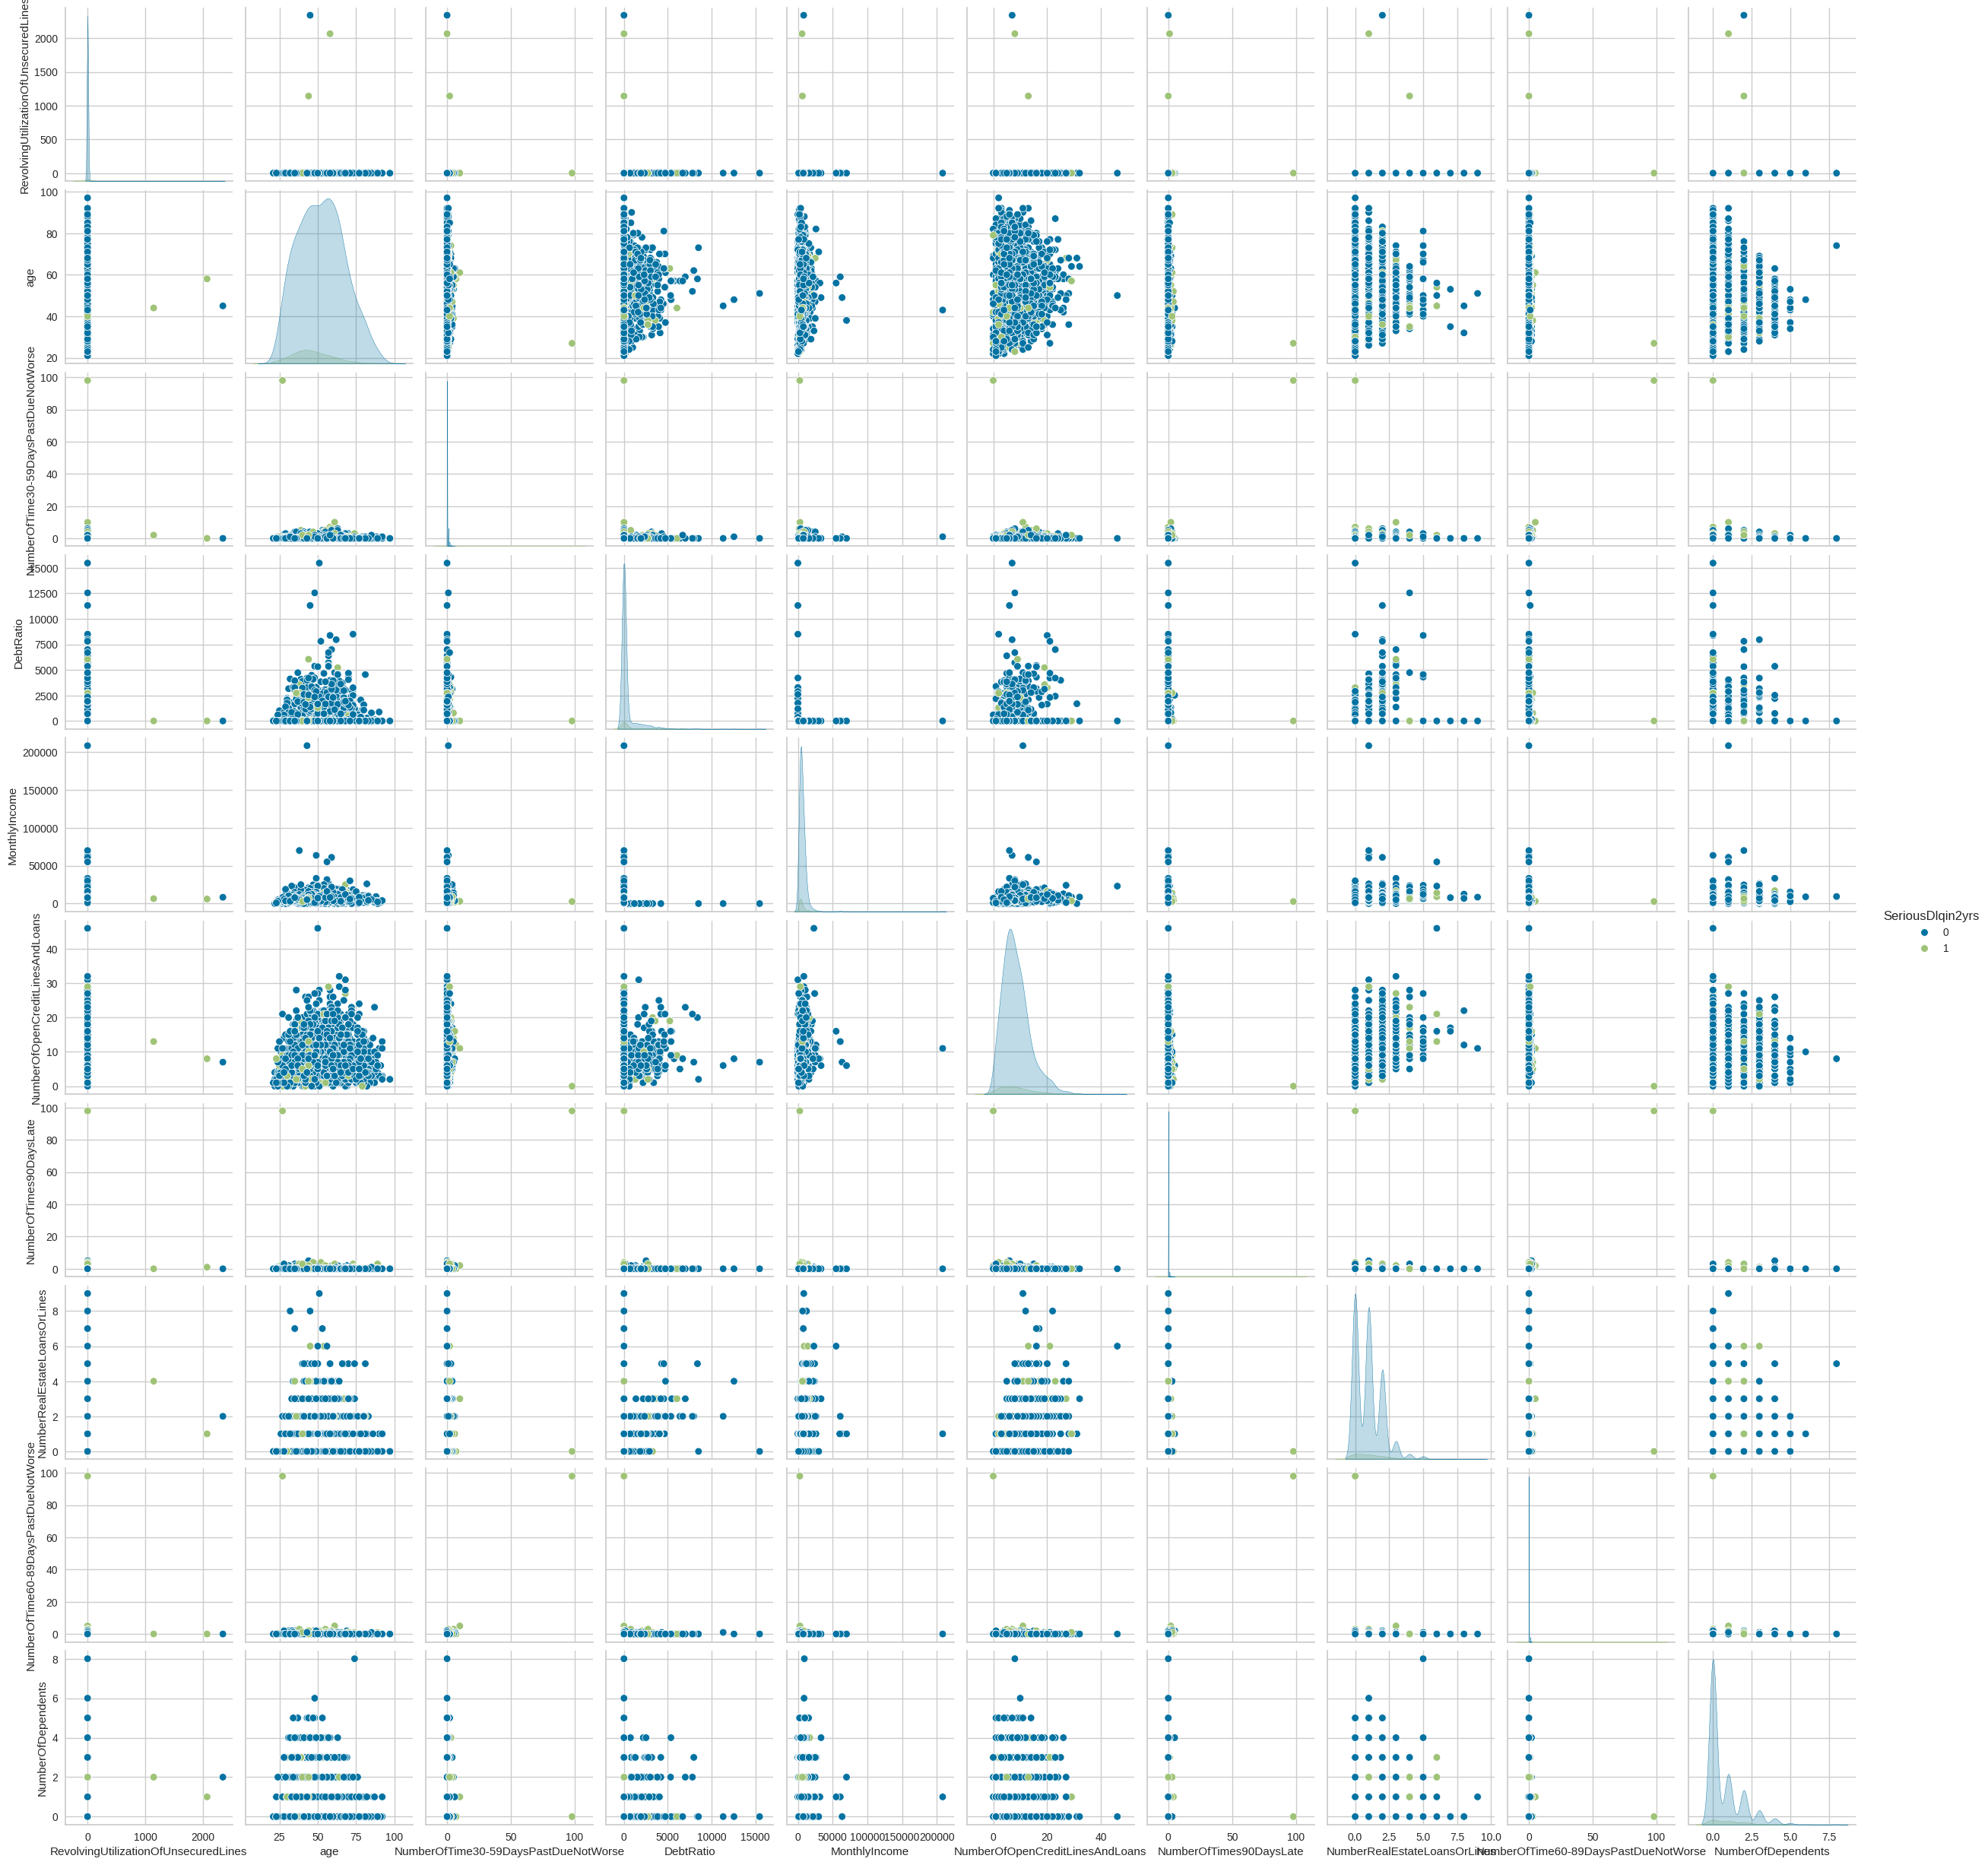

In [227]:
sns.pairplot(data.iloc[0:2000,:], hue= 'SeriousDlqin2yrs')

# Описательный анализ данных 

## Решение проблемы пропусков в наборе данных

Пропущенные значения (NaN) в данных возникают по разным причинам: ошибки при сборе данных, неответы в опросах, сбои оборудования и т.д. Наличие пропусков может сильно исказить выводы модели и статистику.

### Методы обработки:
1. **Удаление пропусков**
   - Полное удаление строк или столбцов с NaN.
   - Просто, но может сильно сократить выборку.

2. **Заполнение статистикой**
   - Среднее/медиана/мода по признаку.
   - Быстро, но не учитывает взаимосвязи между признаками.

3. **Импутация по соседним значениям**
   - Метод ближайших соседей (KNN imputation), линейная регрессия и т.п.
   - Более точная оценка, особенно при MAR.

4. **Модели машинного обучения**
   - Моделирование пропущенного признака как целевой переменной.


### Визуализация пропусков

Для визуализации используется библиотека missingno

<Axes: >

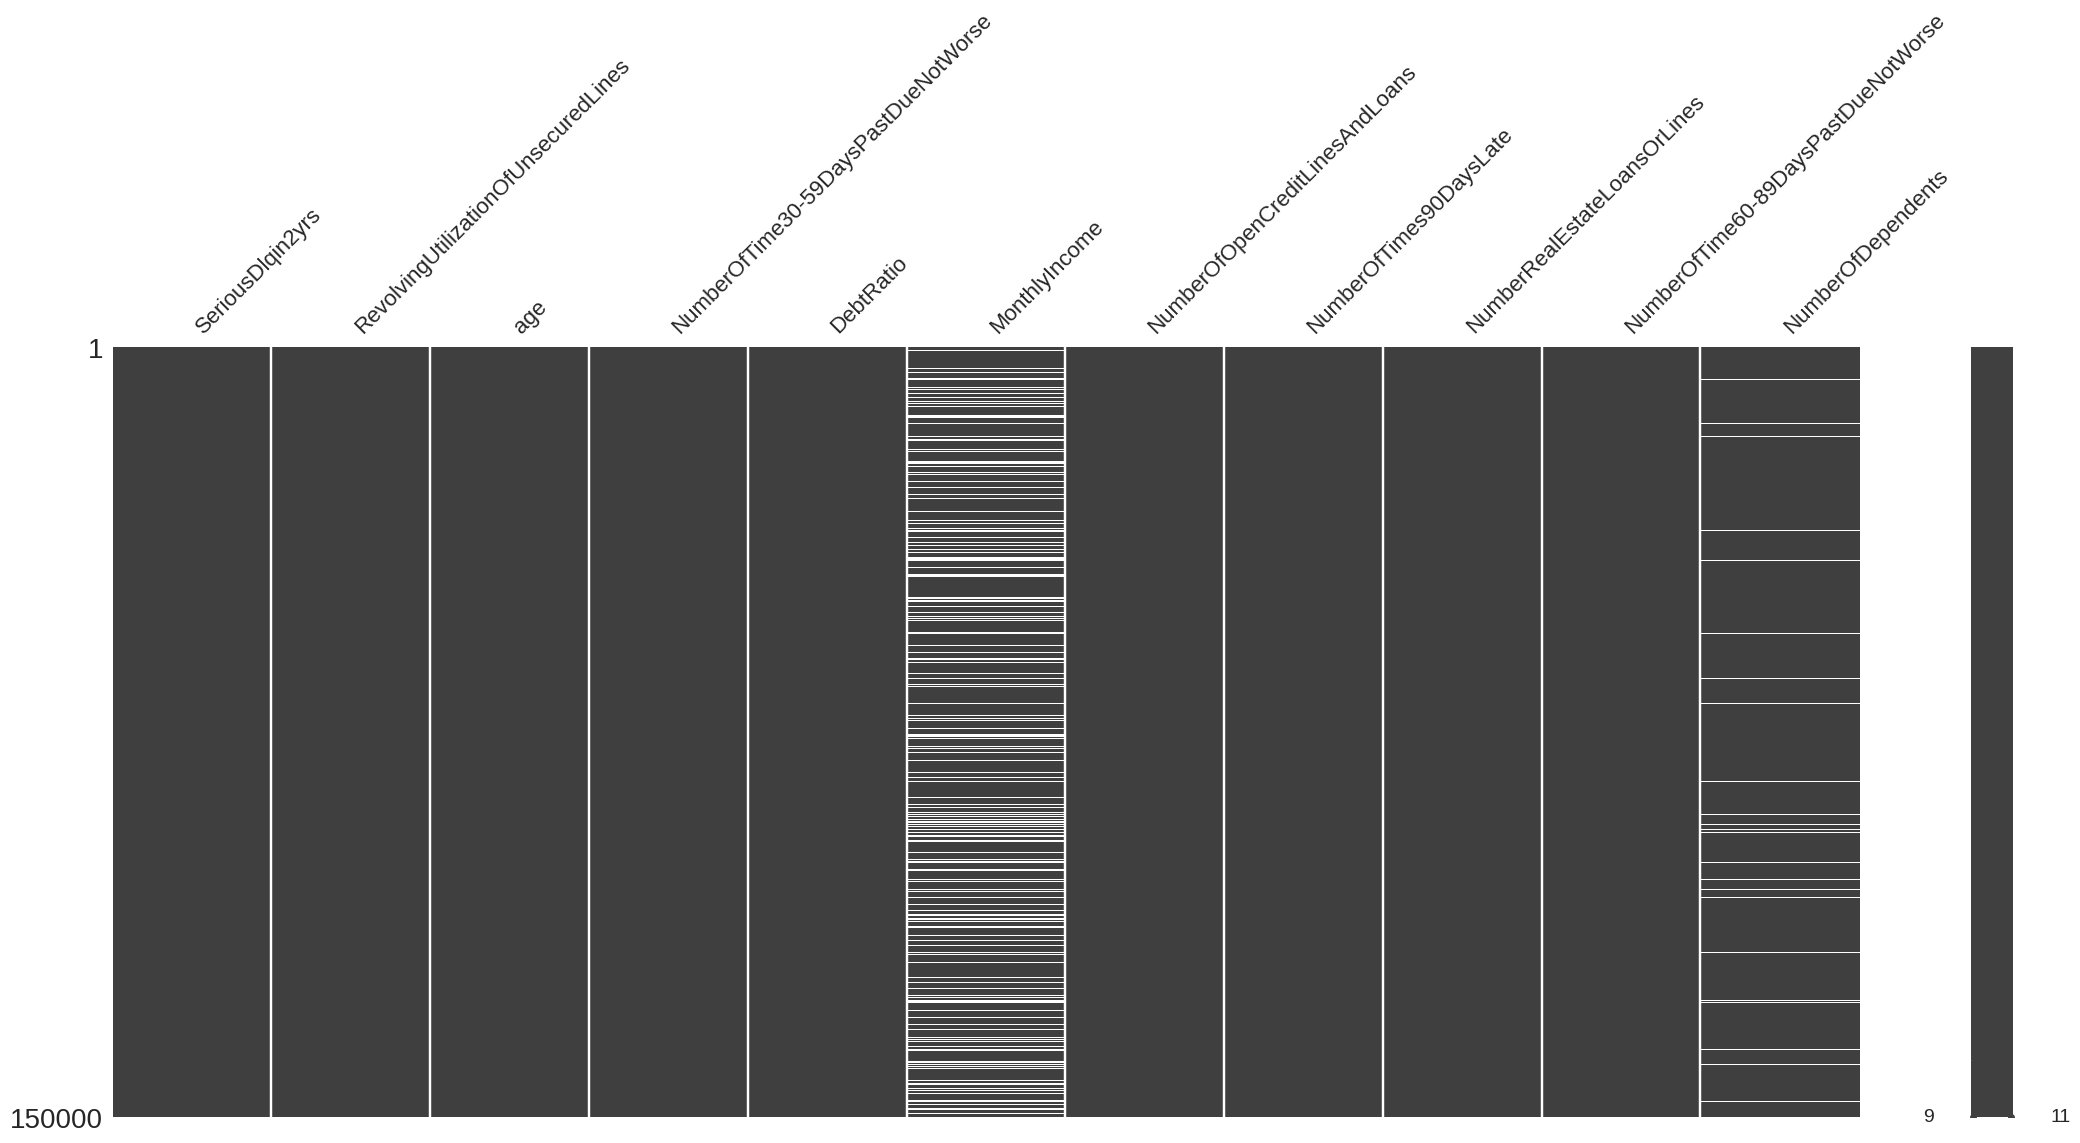

In [228]:
msno.matrix(data)

Как видно выше, пропуски имеются в признаках MonthlyIncome и NumberOfDependents. Объекты с пропусками не удаляются, так как будет потеряна не малая часть обучающей выборки. 

Поэтому пропущенные значения будут восстанавливаться:
- Для **MonthlyIncome**, пропуски в котором составляют примерно 19% от всех данных, будет построен регрессор на основе всеех остальных атрибутов.
- Для **NumberOfDependents**, пропуски в котором составляют примерно 2% от всех данных, значения будут восстановлены медианным значением.

## Восстановление данных в атрибуте NumberOfDependents

In [229]:
data["NumberOfDependents"] = data["NumberOfDependents"].fillna(data["NumberOfDependents"].median())

## Восстановление данных в атрибуте MonthlyIncome

In [230]:
train = data[data["MonthlyIncome"].isnull() == False]
test = data[data["MonthlyIncome"].isnull() == True]

X_train = train.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)
y_train = train["MonthlyIncome"]
X_test = test.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

lmMod = LinearRegression().fit(X_train, y_train)

pred = []
for _ in lmMod.predict(X_test):
    if _ > 0:
        pred.append(_)
    else:
        # Если зарплатала отлична от 0, то заменяю медианным значением
        pred.append(y_train.median())

j = 0
for i in test.index:
    data.loc[i, "MonthlyIncome"] = pred[j] 
    j += 1

<Axes: >

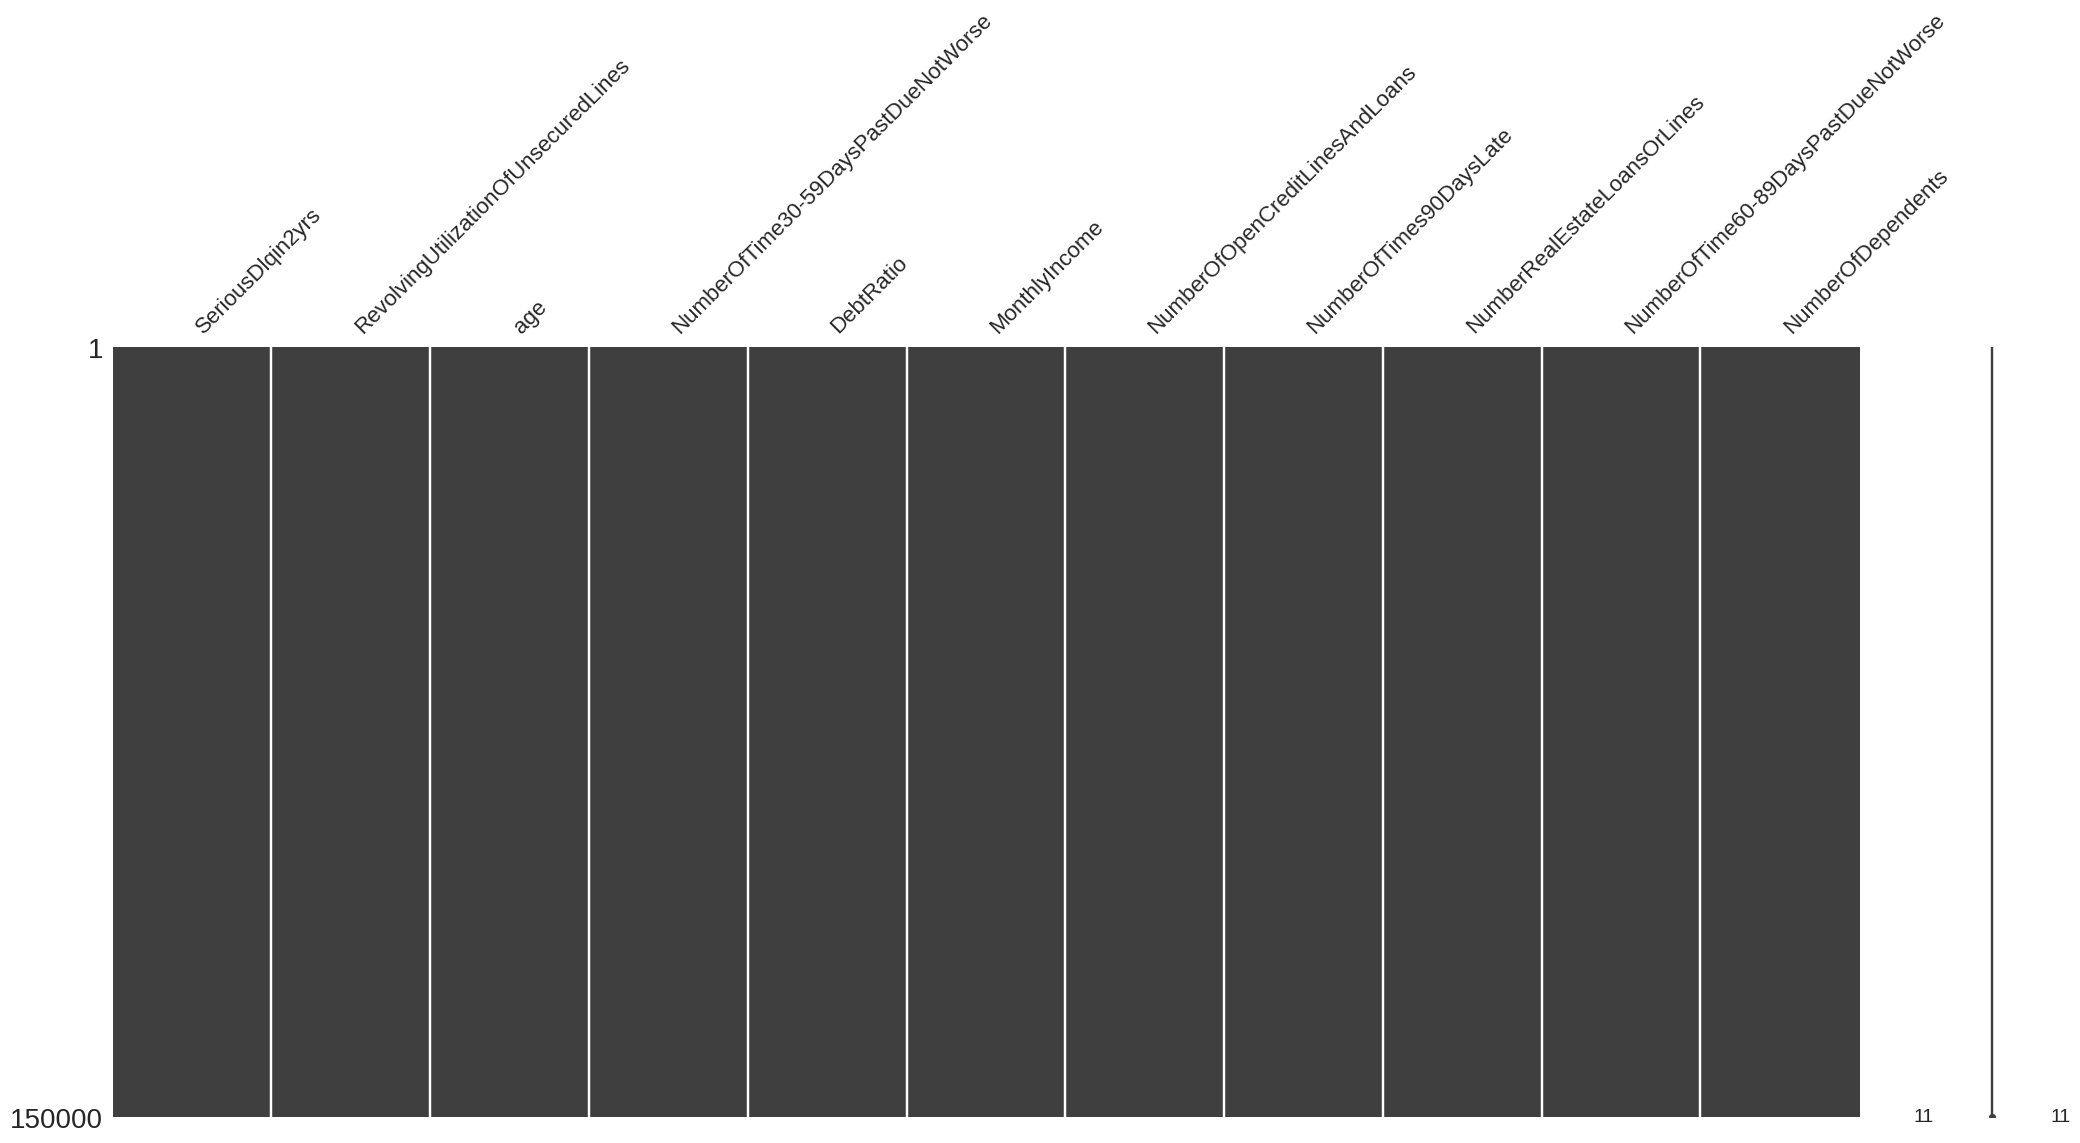

In [231]:
msno.matrix(data)

## Поиск и удаление выбросов

**Выбросы** — это необычные значения, значительно отличающиеся от остальных. Они могут быть следствием ошибок измерения, ошибок в данных или быть настоящими, но крайне редкими случаями.

### Методы выявления:
1. **Статистические методы**
   - IQR (межквартильный размах): значения за границами $Q1 - 1.5×IQR$, $Q3 + 1.5×IQR$.

2. **Машинное обучение**
   - One-Class SVM, Isolation Forest, Local Outlier Factor (LOF) — строят модель "нормальности" и ищут отклонения.

3. **Визуализация**
   - boxplot, scatter-plot, диаграммы распределения.

### Обработка:
- Удаление выбросов.
- Замена на усреднённые значения.
- Логарифмирование или другие преобразования (если выбросы не аномальные, а просто сильно смещены).


### Визуализация выбросов с помощью boxplot

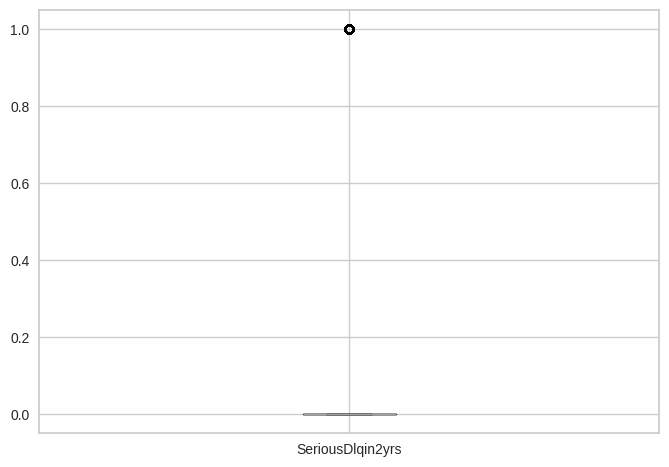

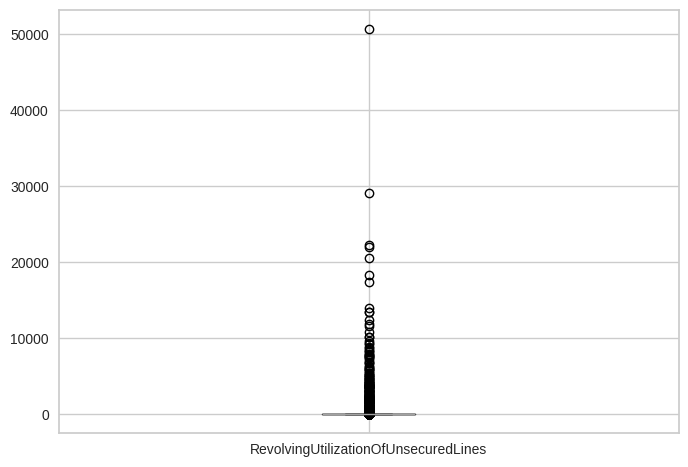

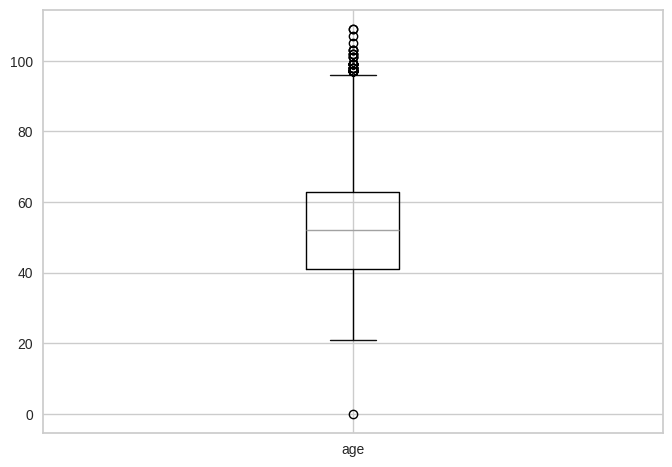

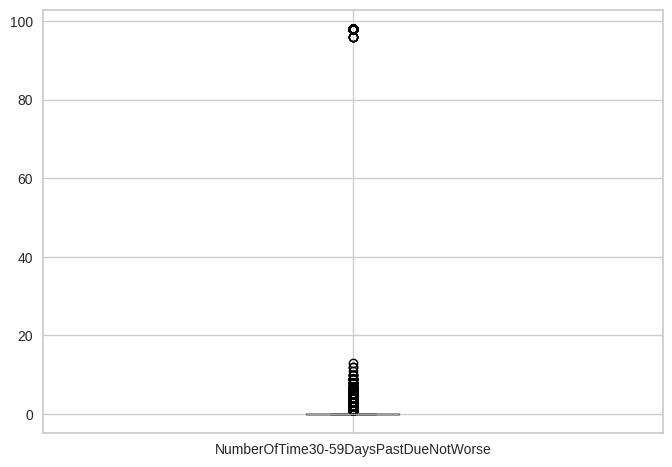

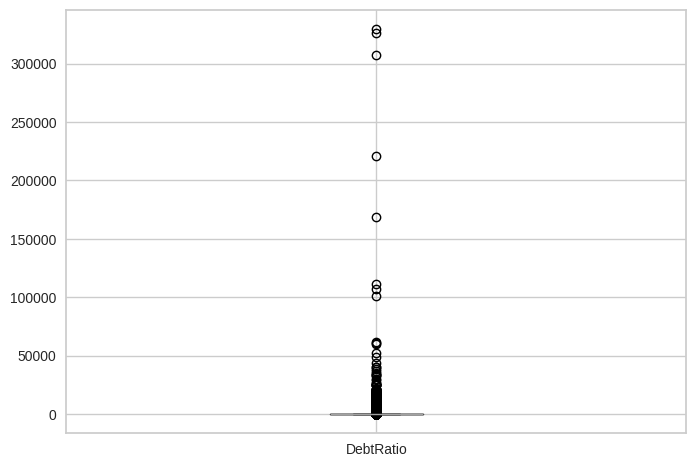

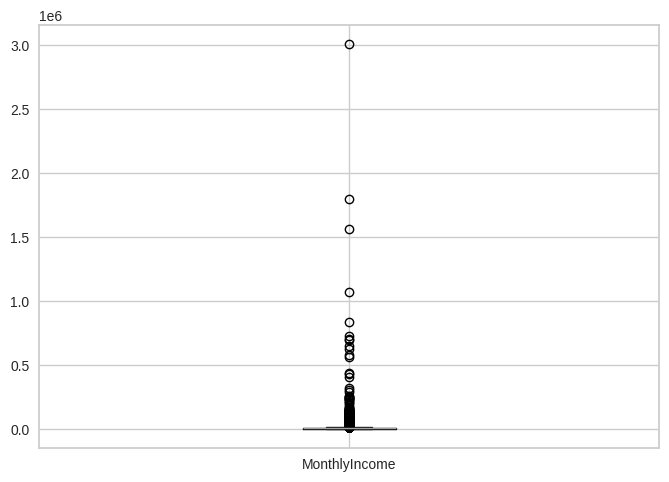

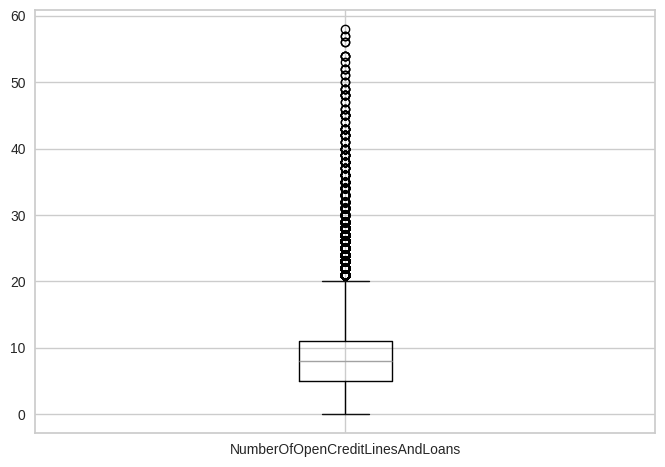

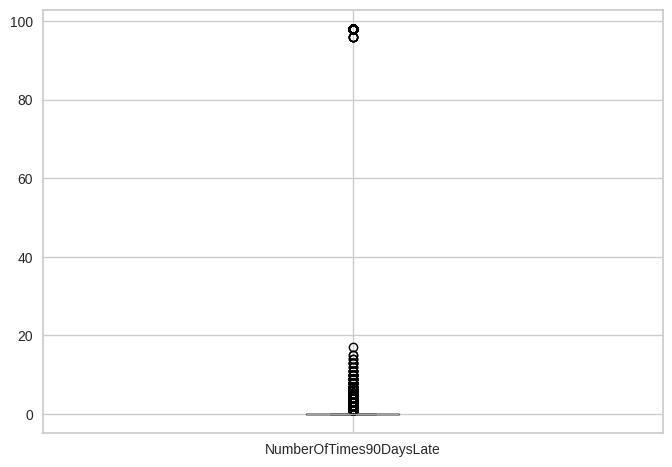

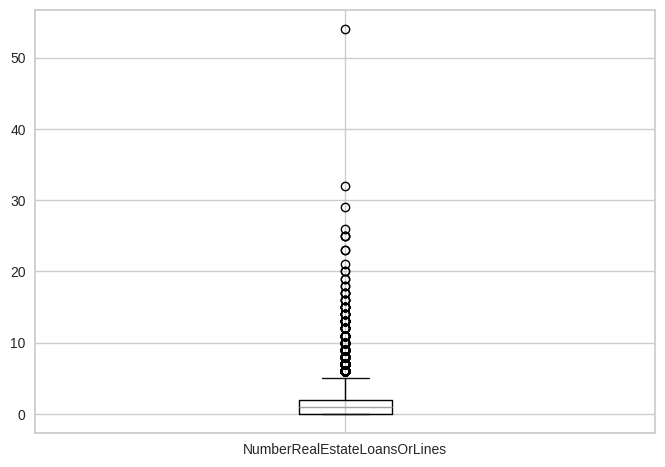

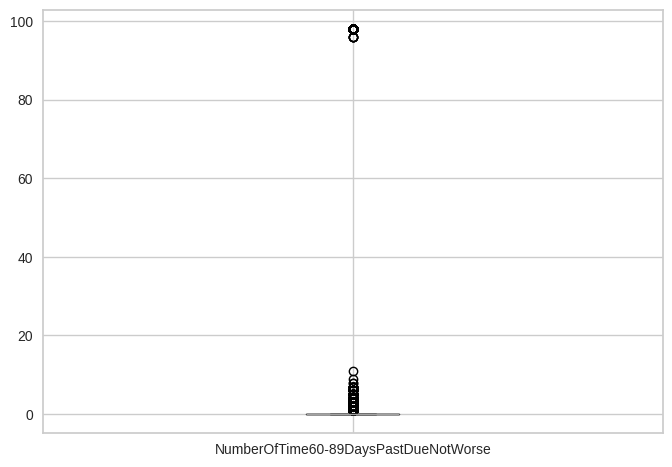

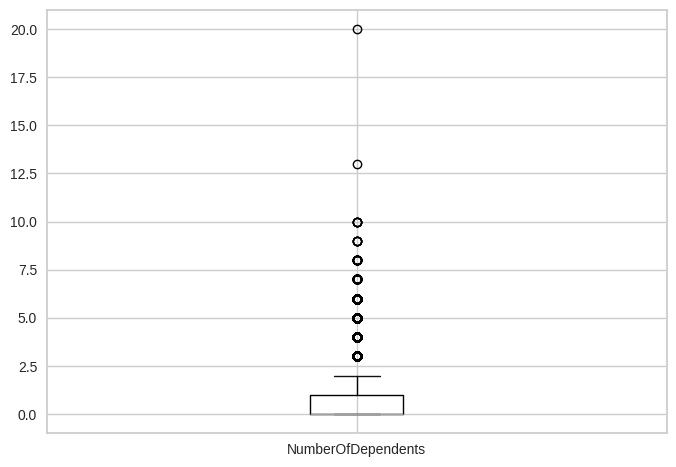

In [232]:
for col in data.columns:
    plt.subplots(1, 1)
    pd.DataFrame(data[col]).boxplot()
    plt.show()

Будут удалены те объекты чьё значение "age" превыщает полтора квартильного размаха или которое меньше 22 лет. Нижняя допустимая граница возраста выбрана из предположения, что, в среднем, человек начинает зарабатывать деньги и, следоватльно, имеет возможность взять кредит, с 22 лет.

In [233]:
topline = data["age"].quantile(0.75) + (data["age"].quantile(0.75) - data["age"].quantile(0.25)) * 1.5 
downline = 22
data = data.drop(data["age"][data["age"] > topline].index)
data = data.drop(data["age"][data["age"] < downline].index)

## Визуализация распределения

Из-за огромного количества данных построить распределения для каждого атрибута по всем данным слишком затратно по времени. Поэтому использую train_test_split из sklearn для создания репрезентативной подвыборки. Обратим внимание на дизбаланс классов в таргете, а именнно на графике "SeriousDlqin2yrs".

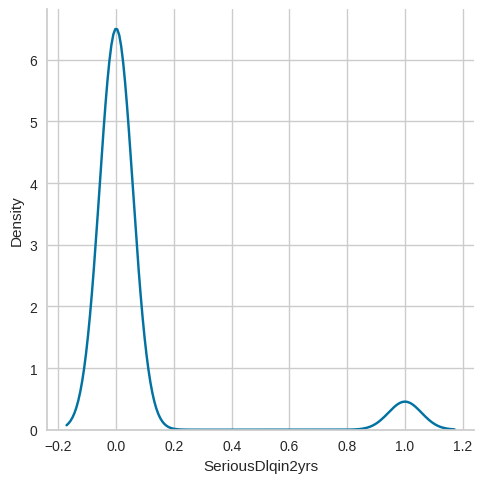

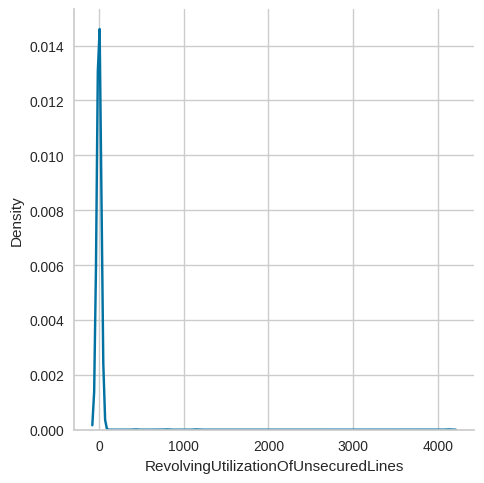

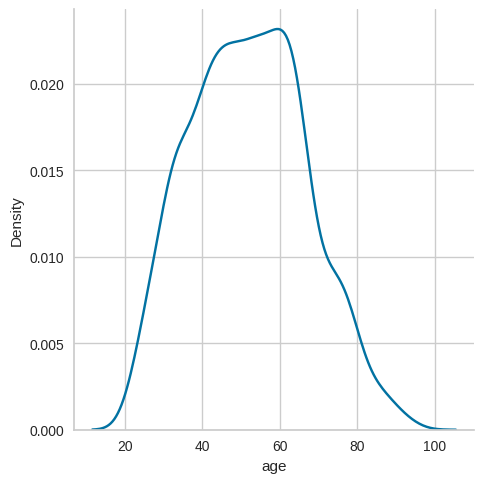

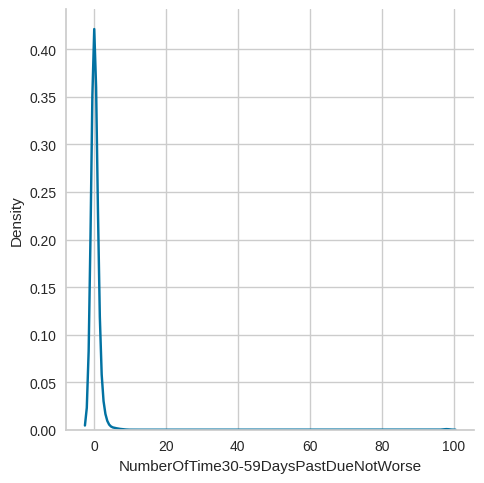

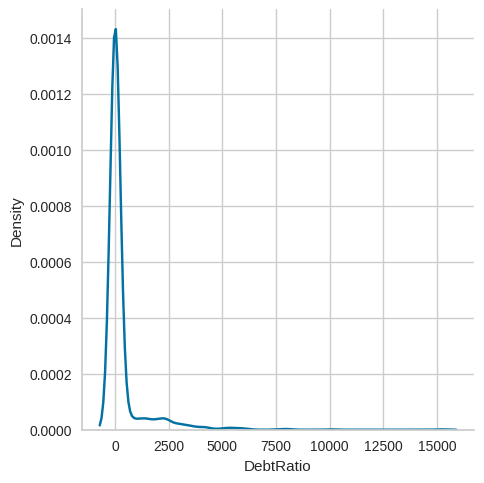

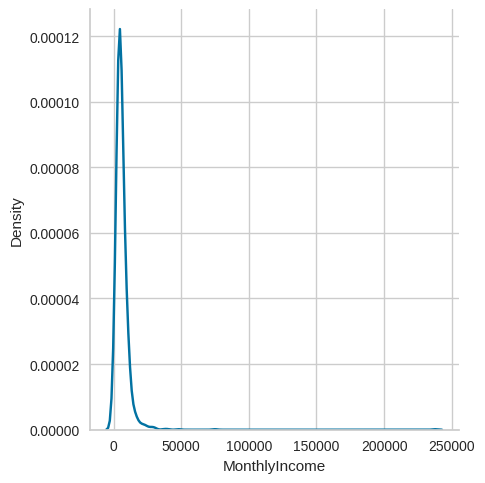

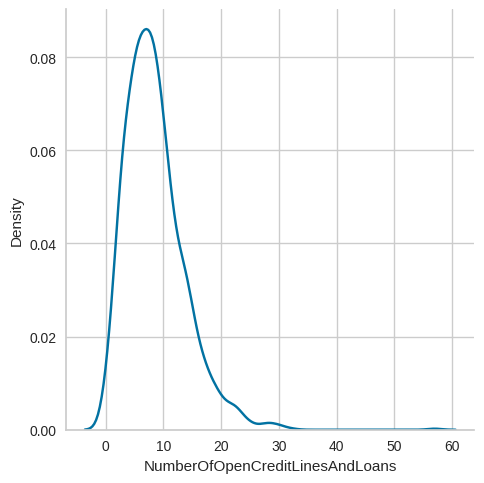

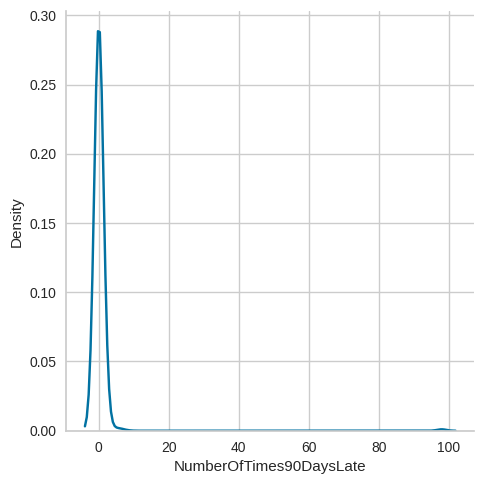

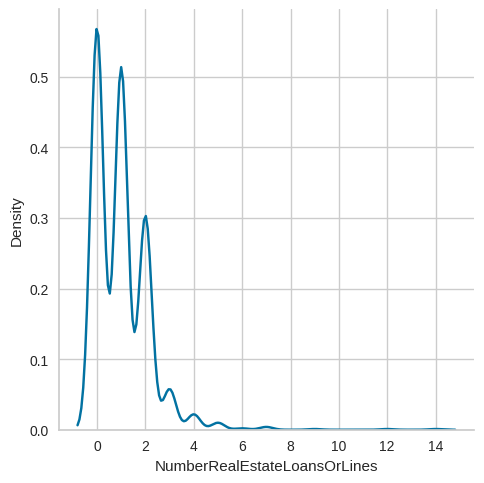

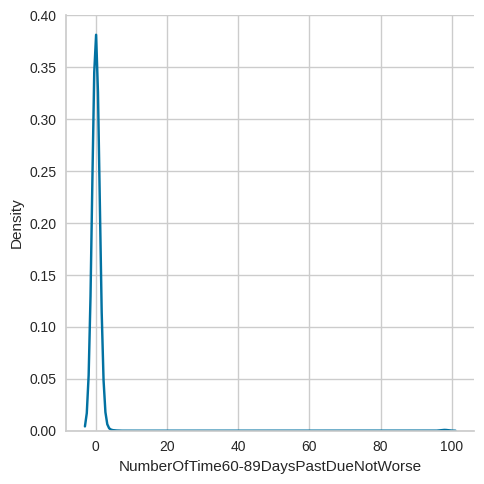

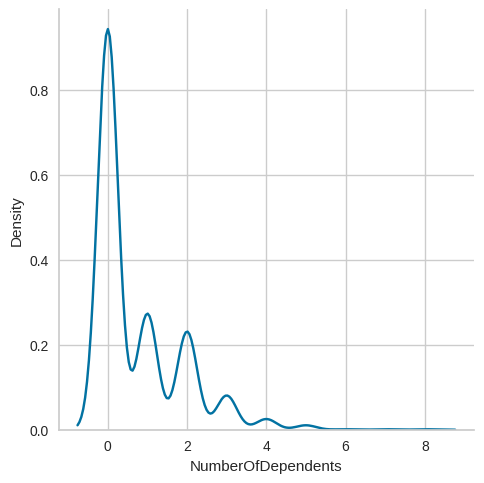

In [234]:
for column in data.columns:
    data_col, _ = train_test_split(data[column], test_size=0.01)
    display(sns.displot(_, kind="kde"))

Как видно, не сбалансированы признаки:
- NumberOfTime30-59DaysPastDueNotWorse
- NumberOfTimes90DaysLate
- NumberOfTime60-89DaysPastDueNotWorse
- NumberOfDependents

Принято решение провести бинаризацию этих признаков. Данное решение принято на основании того, что при оценке клиента на предмет возврата кредита, не столь важно сколько раз он задерживал возврат прошлых кредитов на 90 и более дней, важен сам факт. 

In [235]:
scaler = Binarizer(threshold=0)
data.loc[:, "NumberOfTime30-59DaysPastDueNotWorse"] = scaler.fit_transform(pd.DataFrame(data.loc[:, "NumberOfTime30-59DaysPastDueNotWorse"]))
data.loc[:, "NumberOfTimes90DaysLate"] = scaler.fit_transform(pd.DataFrame(data.loc[:, "NumberOfTime30-59DaysPastDueNotWorse"]))
data.loc[:, "NumberOfTime60-89DaysPastDueNotWorse"] = scaler.fit_transform(pd.DataFrame(data.loc[:, "NumberOfTime30-59DaysPastDueNotWorse"]))
data.loc[:, "NumberOfDependents"] = scaler.fit_transform(pd.DataFrame(data.loc[:, "NumberOfDependents"]))

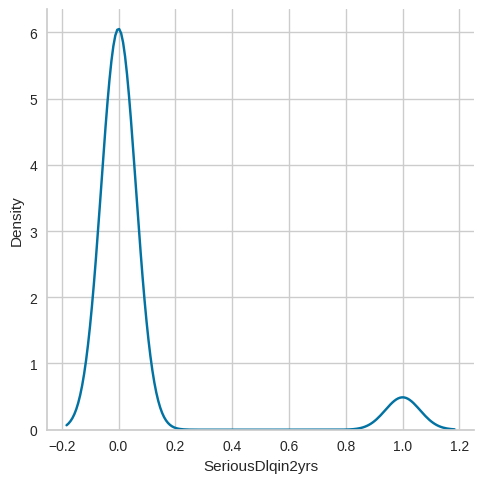

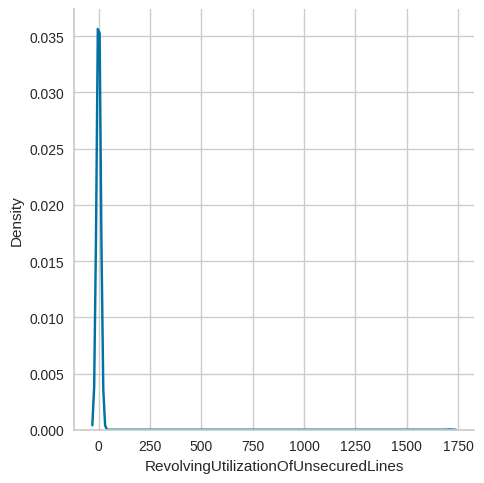

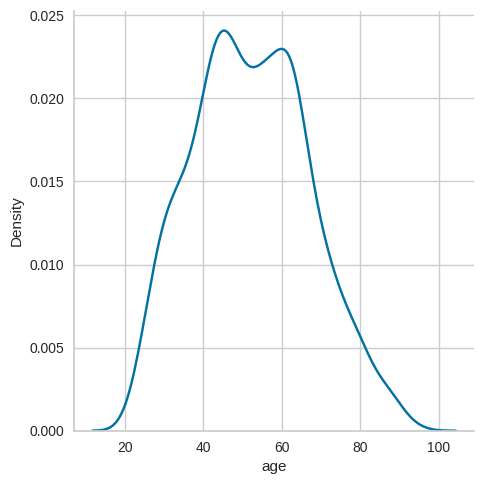

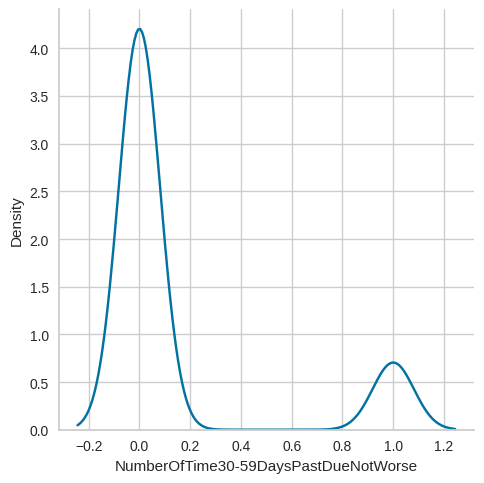

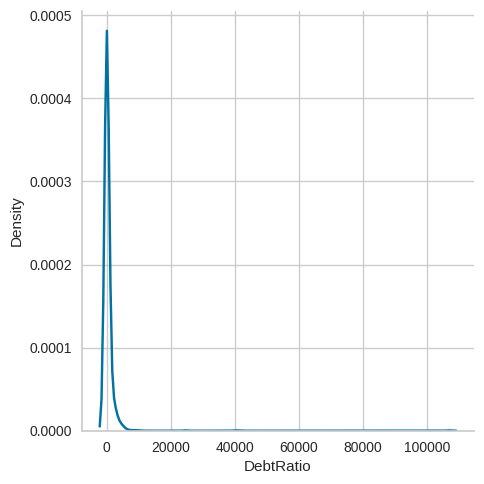

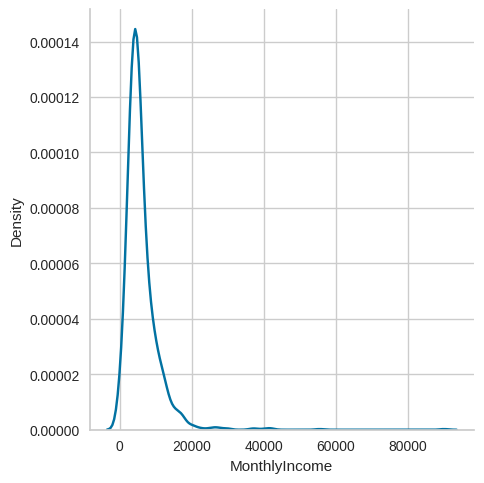

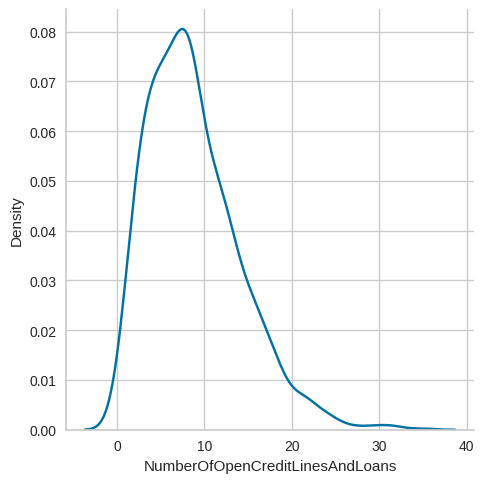

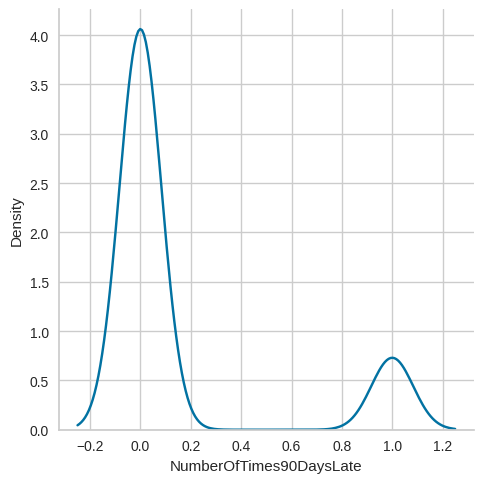

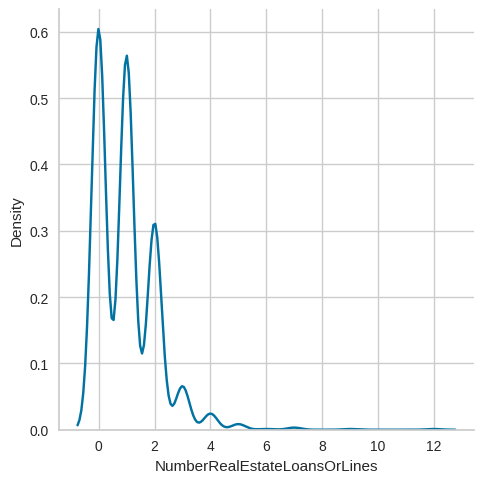

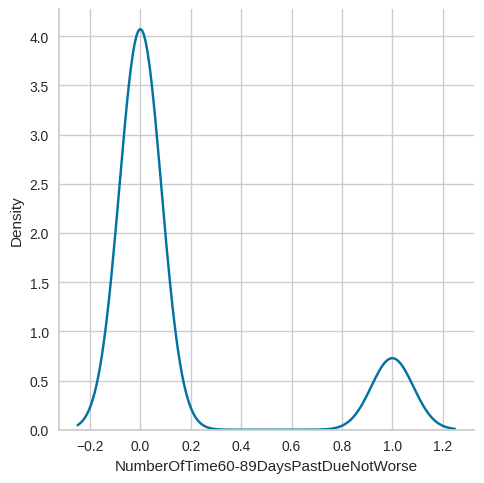

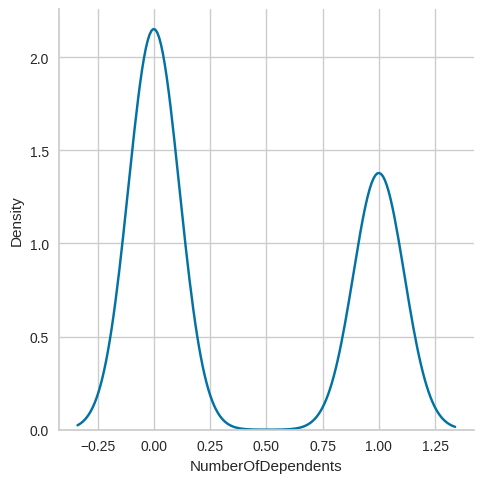

In [236]:
for column in data.columns:
    data_col, _ = train_test_split(data[column], test_size=0.01)
    display(sns.displot(_, kind="kde"))

# Разделение данных на тестовую и обучающую выборки

Из-за огромного количества данных для теста достаточно 0.01 от всего массива данных.

In [237]:
X, y = data[data.columns[1:]], data[data.columns[0]] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  
X_test, X_calibrate, y_test, y_calibrate = train_test_split(X_test, y_test, train_size=1/3, random_state=41)

# Борьба с дизбалансом классов

Когда один класс значительно доминирует над другими, большинство алгоритмов классификации склонны игнорировать малочисленные классы. Это приводит к высокой accuracy, но плохому качеству по другим метрикам.

### Методы борьбы:

1. **Ресемплирование**
   - Oversampling (например, SMOTE): увеличивает число объектов меньшинства.
   - Undersampling: уменьшает количество объектов большинства.
   - Комбинированные методы.

2. **Изменение метрик**
   - Использование F1-score, ROC-AUC, Precision-Recall вместо accuracy.

3. **Взвешивание классов**
   - Передача весов классов в модель (например, class_weight="balanced" в sklearn).

4. **Генерация синтетических примеров**
   - SMOTE, ADASYN: генерируют искусственные точки для миноритарного класса.


Из-за дизбаланса классов решено добавить синтетических данных с использлованием **ADASYN**.


## ADASYN

**ADASYN** — это алгоритм генерации синтетических примеров для миноритарного класса, являющийся развитием метода **SMOTE**. Главное отличие: ADASYN создаёт больше новых примеров **в тех зонах пространства, где миноритарный класс плохо представлен**, т.е. адаптивно усиливает сложные области.

### Алгоритм ADASYN:

1. Для каждого примера миноритарного класса оценивается его "сложность":
   - Считается, сколько соседей среди ближайших K — это объекты из другого класса.
   - Чем больше таких соседей, тем сложнее точка, и тем больше ей нужно "усиления".

2. Вычисляется общее количество новых примеров, которые нужно сгенерировать.

3. Новые точки создаются как линейные комбинации исходной точки и её ближайших соседей (как в SMOTE), но количество сэмплов на каждую точку определяется её "сложностью".

### Преимущества:
- ADASYN не просто выравнивает классы, а **умно перераспределяет внимание** к сложным регионам.
- Может улучшить качество классификации, особенно если дисбаланс неравномерно выражен.

### Недостатки:
- При сильной зашумленности данных может усиливать шум.
- Как и любой oversampling, может увеличить время обучения модели.

In [238]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN()

X_train, y_train = adasyn.fit_resample(X_train, y_train)

## Корреляционная матрица

In [239]:
def draw_cov(data):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title('Confusion Matrix')
    sns.heatmap(data.corr(), annot=True, fmt="0.0%", linewidth=0.1)

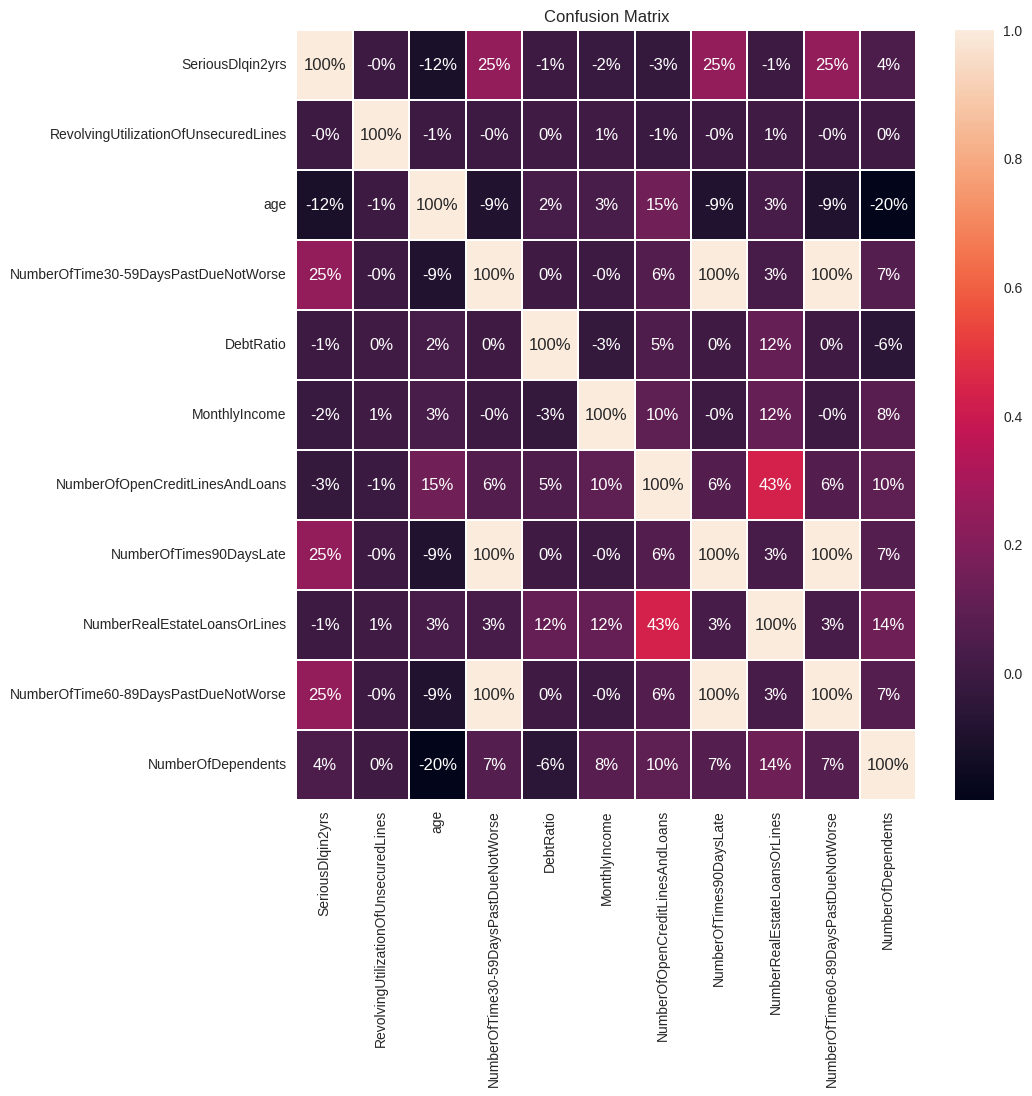

In [240]:
draw_cov(data)

# Выявление наиболее информативных признаков

Не все признаки одинаково важны. Некоторые из них шумовые, другие — избыточные.

### Методы выбора признаков:
1. **Фильтрационные методы (Filter)**
   - Основаны на статистических метриках: дисперсия, корреляция, $\chi^2$, mutual information.
   - Быстрые, не зависят от модели.

2. **Обёрточные методы (Wrapper)**
   - Перебор подмножеств признаков с использованием модели.
   - Пример: RFE (Recursive Feature Elimination).

3. **Методы встроенного отбора (Embedded)**
   - Отбор встроен в обучение модели.
   - Пример: регуляризация Lasso (L1), дерево решений, Random Forest importance.

Эта часть анализа выполнена с помощью Random Forest importance - обученный на всей выборке, модель случайного леса покажет информативность и вариативность каждого отдельного атрибута. 

In [241]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

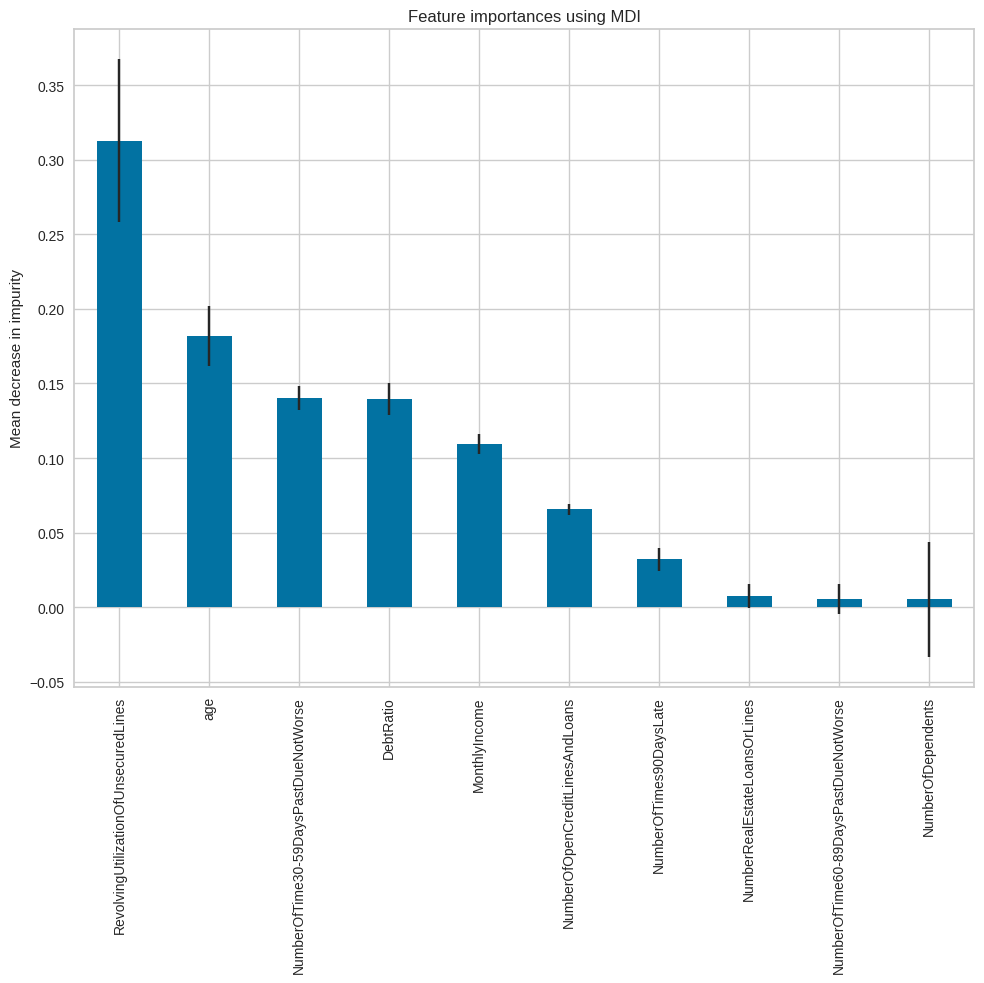

In [242]:
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks(np.arange(0, 10, 1), labels=X.columns.tolist())
fig.tight_layout()

Анализ атрибутов с помощью случайного леса показал, что наиболее информативными признаками являются:
- RevolvingUtilizationOfUnsecuredLines
- age
- NumberOfTime30-59DaysPastDueNotWorse
- DebtRatio
- MonthlyIncome
- NumberOfOpenCreditLinesAndLoans

## PCA

PCA — метод понижения размерности, позволяющий представить данные в новом пространстве меньшей размерности с сохранением максимально возможной доли дисперсии.

### Применения:
- Визуализация данных в 2D/3D.
- Удаление шумов.
- Снижение размерности перед обучением модели.

Теперь применим PCA к выявленным ранее наиболее информативным признакам, возможно получиться понизить размерность с сохранением большей дисперсии данных. Заодно избавимся от возможного шума.

In [243]:
X_random_forest = X.loc[:,["RevolvingUtilizationOfUnsecuredLines", 
                           "age", 
                           "NumberOfTime30-59DaysPastDueNotWorse", 
                           "DebtRatio", 
                           "MonthlyIncome",
                           "NumberOfOpenCreditLinesAndLoans"]]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_random_forest)

pca_machine = PCA(n_components=min(X_random_forest.shape[0], X_random_forest.shape[1]), svd_solver="covariance_eigh")

pca_X = pca_machine.fit(pd.DataFrame(scaled_X, columns=X_random_forest.columns.values))

pca_importances = pd.Series(pca_X.explained_variance_ratio_, index=pca_X.get_feature_names_out())

Общая объясненная дисперсия 1.0


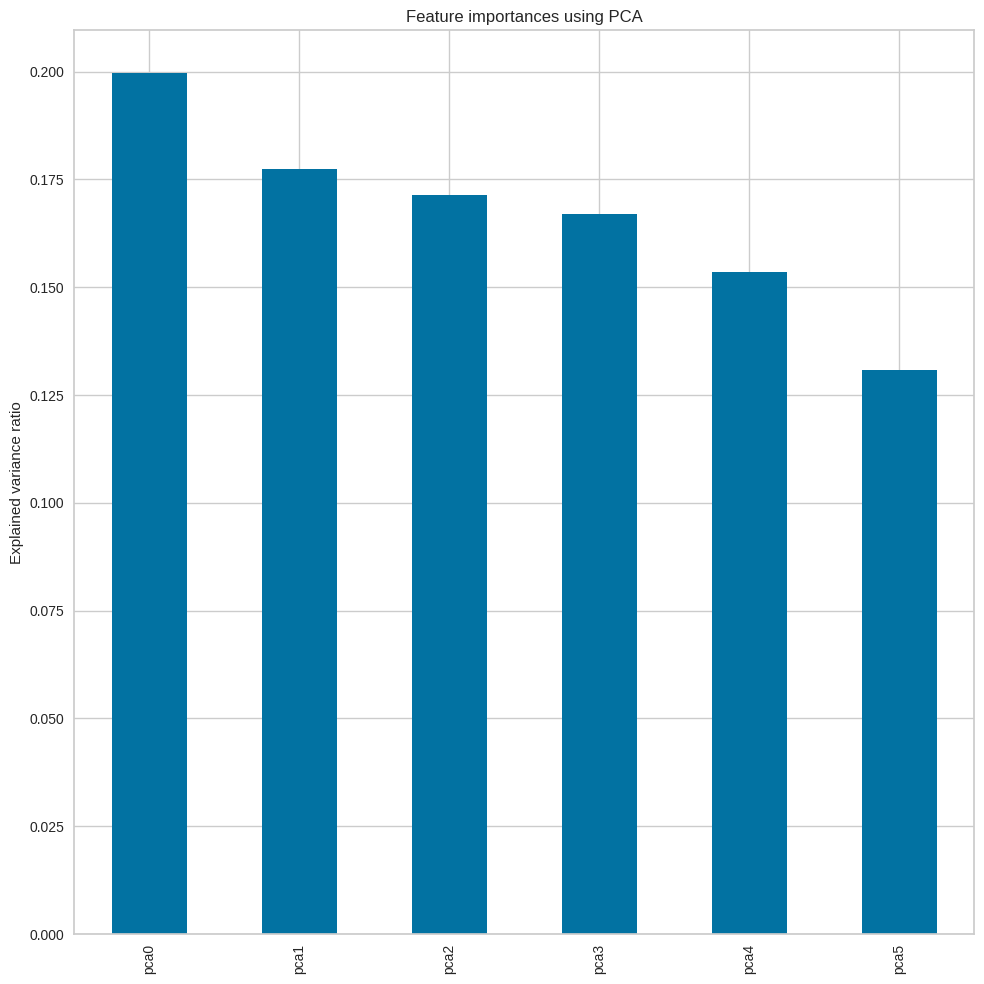

In [244]:
fig, ax = plt.subplots(figsize=(10,10))
pca_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using PCA")
ax.set_ylabel("Explained variance ratio")
ax.set_xticks(np.arange(0, X_random_forest.shape[1], 1), labels=pca_X.get_feature_names_out())
fig.tight_layout()

most_explainde_pca_X = pca_X.explained_variance_ratio_
print(f"Общая объясненная дисперсия {most_explainde_pca_X.sum()}")

transformed_X = pca_machine.transform(pd.DataFrame(scaled_X, columns=X_random_forest.columns.values))

# Подбор моделей

Далее представлены базовые модели и сравнительная табилца по основным метрикам, таким как:
- accuracy
- precision
- recall
- f1
- train_time

In [245]:
models_info = {"model": [], 
               "accuracy": [],
               "precision": [],
               "recall": [],
               "f1": [],
               "train_time": []}

def add_new_row(model, train_time, X_test, y_true):
    y_pred = model.predict(X_test)
    models_info["model"].append(type(model).__name__)
    models_info["accuracy"].append(accuracy_score(y_true, y_pred))
    models_info["precision"].append(precision_score(y_true, y_pred))
    models_info["recall"].append(recall_score(y_true, y_pred))
    models_info["f1"].append(f1_score(y_true, y_pred))
    models_info["train_time"].append(train_time)

## DecisionTreeClassifier

In [246]:
start = time.time()
model_DT = DecisionTreeClassifier().fit(X_train, y_train)
end = time.time()

In [247]:
add_new_row(model_DT, end - start, X_test, y_test)

print(f"ROC_AUC: {roc_auc_score(y_test, model_DT.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_DT, X, y, scoring="roc_auc"))}")

ROC_AUC: 0.6118589743589743
 Cross validation score: 0.5821627827760751


## GaussianNB

In [248]:
start = time.time()
model_GNB = GaussianNB().fit(X_train, y_train)
end = time.time()

In [249]:
add_new_row(model_GNB, end - start, X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_GNB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GNB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5553418803418804
 Cross validation score: 0.754908174232896


## LogisticRegression

In [250]:
start = time.time()
model_LogReg = LogisticRegression().fit(X_train, y_train)
end = time.time()

In [251]:
add_new_row(model_LogReg, end - start, X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_LogReg.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_LogReg, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.688034188034188
 Cross validation score: 0.7481829714470718


## Random Forest

In [252]:
start = time.time()
model_RF = RandomForestClassifier().fit(X_train, y_train)
end = time.time()

In [253]:
add_new_row(model_RF, end - start, X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_RF.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_RF, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.6523504273504273
 Cross validation score: 0.8041130883175924


## Gradient Boosting

In [254]:
start = time.time()
model_GB = GradientBoostingClassifier().fit(X_train, y_train)
end = time.time()

In [255]:
add_new_row(model_GB, end - start ,X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_GB.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_GB, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.713568376068376
 Cross validation score: 0.8343420488344714


## KNN

In [256]:
start = time.time()
model_KNN = KNeighborsClassifier().fit(X_train, y_train)
end = time.time()

In [257]:
add_new_row(model_KNN, end - start ,X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_KNN.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_KNN, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.5668803418803419
 Cross validation score: 0.5650555342732362


## Neural Network

In [258]:
start = time.time()
model_MLP = MLPClassifier().fit(X_train, y_train)
end = time.time()

In [259]:
add_new_row(model_MLP, end - start, X_test, y_test)

print(f" ROC_AUC: {roc_auc_score(y_test, model_MLP.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_MLP, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.7368589743589744
 Cross validation score: 0.6401309476060285


## AdaBoosting

In [260]:
start = time.time()
model_Ada = AdaBoostClassifier().fit(X_train, y_train)
end = time.time()

In [261]:
add_new_row(model_Ada, end - start, X_test, y_test)


print(f" ROC_AUC: {roc_auc_score(y_test, model_Ada.predict(X_test))}\n Cross validation score: {np.mean(cross_val_score(model_Ada, X, y, scoring="roc_auc"))}")

 ROC_AUC: 0.7493589743589744
 Cross validation score: 0.8264887834338414


Посмотрим на получившуюся таблицу с моделями и их эффективностью.

Из неё видно, что три лучших модели это:
- **AdaBoostClassifier**
- **GradientBoostingClassifier**

In [262]:
pd.DataFrame(models_info)

,model,accuracy,precision,recall,f1,train_time
0,DecisionTreeClassifier,0.796675,0.131165,0.400641,0.197628,1.273758
1,GaussianNB,0.216747,0.070234,0.942308,0.130725,0.026445
2,LogisticRegression,0.745994,0.144345,0.621795,0.234300,3.736505
3,RandomForestClassifier,0.858574,0.198777,0.416667,0.269151,28.058238
4,GradientBoostingClassifier,0.805088,0.182517,0.608974,0.280857,28.630593
5,KNeighborsClassifier,0.720753,0.092006,0.391026,0.148962,0.237836
6,MLPClassifier,0.641226,0.131540,0.846154,0.227684,235.936064
7,AdaBoostClassifier,0.760016,0.170877,0.737179,0.277443,5.671974


# Подбор гиперпараметров

В большинстве моделей машинного обучения есть гиперпараметры — значения, которые нельзя напрямую обучить на данных (в отличие от параметров модели). 

### Подходы к подбору:

1. **Grid Search**
   - Перебирает все возможные комбинации из заданной сетки.
   - Простой, но крайне неэффективный в высоких размерностях.

2. **Random Search**
   - Случайный перебор гиперпараметров в заданных диапазонах.
   - Быстрее находит "достаточно хорошие" комбинации, особенно если только часть гиперпараметров важна.

3. **Байесовская оптимизация**
   - Использует вероятностную модель (обычно — Гауссовский процесс или дерево решений), чтобы аппроксимировать функцию качества.
   - На каждом шаге выбирает гиперпараметры, которые **максимизируют функцию приобретения** (expected improvement и т.д.).
   - Обеспечивает баланс **исследования** (exploration) и **эксплуатации** (exploitation).

Байесовская оптимизация **учится** на предыдущих итерациях, чтобы предсказывать, где может быть улучшение.

Но перед тем, как приступить к оптимизации нужно получить все численные параметры, так как реализованная в рамках курсовой работы байесовская оптимизация не приспособлена к работе с категориальными данными!

Качество модели в оптимизации оценивется с помощью метрики precision.

In [263]:
def get_model_numeric_params(model):
    for key, value in model.get_params().items():
        if not isinstance(value, str) and not isinstance(value, type(None)):
            print(f"{key} {type(value)}")

def get_scores(model, X_test, y_true):
    y_pred = model.predict(X_test)
    print(f"accuracy_score: {accuracy_score(y_true, y_pred)}")
    print(f"precision_score: {precision_score(y_true, y_pred)}")
    print(f"recall_score: {recall_score(y_true, y_pred)}")
    print(f"f1_score: {f1_score(y_true, y_pred)}")
    print(f"ROC_AUC: {roc_auc_score(y_test, y_pred)}")

def get_cross_val_scores(model, X, y):
    print(f"accuracy_score: {np.mean(cross_val_score(model, X, y, scoring="accuracy"))}")
    print(f"precision_score: {np.mean(cross_val_score(model, X, y, scoring="precision"))}")
    print(f"recall_score: {np.mean(cross_val_score(model, X, y, scoring="recall"))}")
    print(f"f1_score: {np.mean(cross_val_score(model, X, y, scoring="f1_macro"))}")
    print(f"ROC_AUC: {np.mean(cross_val_score(model_Ada, X, y, scoring="roc_auc"))}")

## Настройка гиперпараметров GradientBoostingClassifier с помощью байесовсокой оптимизации

In [264]:
get_model_numeric_params(GradientBoostingClassifier())

ccp_alpha <class 'float'>
learning_rate <class 'float'>
max_depth <class 'int'>
min_impurity_decrease <class 'float'>
min_samples_leaf <class 'int'>
min_samples_split <class 'int'>
min_weight_fraction_leaf <class 'float'>
n_estimators <class 'int'>
subsample <class 'float'>
tol <class 'float'>
validation_fraction <class 'float'>
verbose <class 'int'>
warm_start <class 'bool'>


In [265]:
from bayes_opt_class import BayesOptimization

params = {"learning_rate": (float, [0, 1]),
          "n_estimators": (int, [2, 10]),
          "max_depth": (int, [1, 10]),
          "min_samples_leaf": (int, [2, 10]),
          "min_samples_split": (int, [2, 10]),
          "tol": (float, [0, 1])}

score, params = BayesOptimization(GradientBoostingClassifier(), params, n_iters=100, scoring="roc_auc").fit(X_calibrate, y_calibrate)
print(f"best score: {score}")
print(f"best params: {params}")

best score: 0.930602410121689
best params: {'learning_rate': np.float64(0.6927379663948798), 'n_estimators': np.float64(5.0), 'max_depth': np.float64(1.0), 'min_samples_leaf': np.float64(7.0), 'min_samples_split': np.float64(6.0), 'tol': np.float64(0.7970610534538746)}


### Посмотрим на результат

In [266]:
# все параметры возвращаются в формате float, но некоторые их них необходимо подавать в формате int  
for key, value in params.items():
    if int(value) - value == 0:
        params[key] = int(value)
params

{'learning_rate': np.float64(0.6927379663948798),
 'n_estimators': 5,
 'max_depth': 1,
 'min_samples_leaf': 7,
 'min_samples_split': 6,
 'tol': np.float64(0.7970610534538746)}

In [267]:
%time
model_GB = GradientBoostingClassifier(**params).fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.34 μs


In [268]:
print("Scores:")
get_scores(model_GB, X_test, y_test)

Scores:
accuracy_score: 0.6534455128205128
precision_score: 0.13340227507755947
recall_score: 0.8269230769230769
f1_score: 0.22974176313446126
ROC_AUC: 0.7344017094017092


## Анализ модели

### Кривые переобучения

Кривые обучения (или кривые переобучения) — это графики, показывающие, как изменяется качество модели на обучающей и валидационной выборках в зависимости от размера обучающей выборки или от количества итераций обучения.

Они являются инструментом диагностики переобучения (overfitting) и недообучения (underfitting).

#### Оси кривой обучения:

- X-ось: Количество обучающих примеров (или эпох / итераций).
- Y-ось: Ошибка (или метрика качества, например, accuracy, loss) на обучающей и валидационной выборках.

#### Сценарии поведения кривых:

##### 1. Недообучение (Underfitting)
- Ошибки на train и val высокие.
- Модель недостаточно сложна, не способна уловить закономерности.
- Кривые расположены высоко и близко друг к другу.

##### 2. Переобучение (Overfitting)
- Ошибка на train низкая, а на val высокая.
- Модель слишком хорошо "запомнила" тренировочные данные и не обобщает.
- Между кривыми большой разрыв.

##### 3. Хорошее обобщение
- Ошибки на train и val невелики.
- Разрыв между кривыми небольшой.
- Обе кривые сходятся (или стабилизируются) с ростом объёма данных.

Ниже представлены графики переобучения на тренировочных и калибровочных данных, чтобы понимать как ведёт себя модель при обучении и насколько хорошо она ведёт себя на "реальных данных".

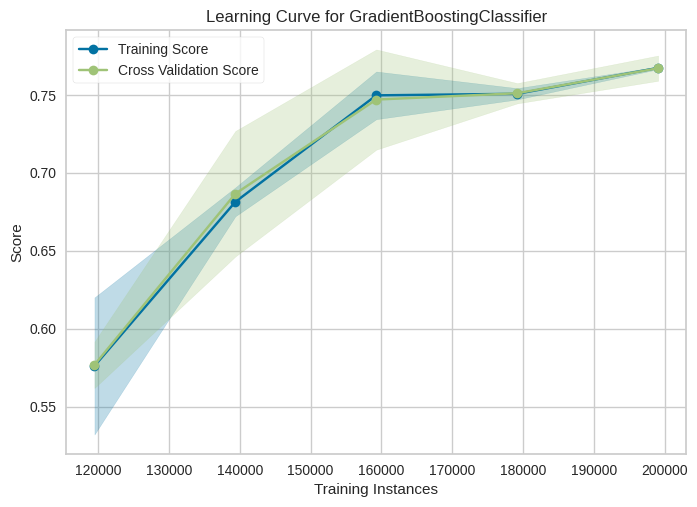

In [269]:
metric = make_scorer(roc_auc_score, response_method="predict")
visualizer = LearningCurve(
    GradientBoostingClassifier(**params), scoring=metric, cv=StratifiedKFold(), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_train, y_train).show()

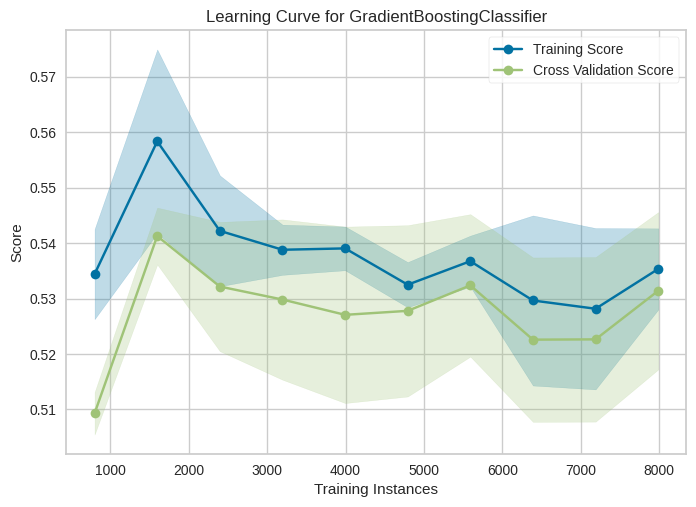

In [270]:
metric = make_scorer(roc_auc_score, response_method="predict")
visualizer = LearningCurve(
    GradientBoostingClassifier(**params), scoring=metric, cv=StratifiedKFold(), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_calibrate, y_calibrate).show()

### Матрица несоответский (Confusion Matrix)

Матрица несоответствий — это табличное представление результатов классификации, используемое для оценки качества модели. Она позволяет увидеть, сколько объектов из каждого класса были правильно или неправильно классифицированы.

Для бинарной классификации матрица имеет следующий вид:

|               | Предсказано: Положительное | Предсказано: Отрицательное |
|---------------|----------------------------|-----------------------------|
| Истинное: Положительное | True Positive (TP)            | False Negative (FN)           |
| Истинное: Отрицательное | False Positive (FP)           | True Negative (TN)            |

#### Обозначения:
- TP (True Positive) — количество объектов положительного класса, которые модель правильно предсказала как положительные.
- TN (True Negative) — количество объектов отрицательного класса, которые модель правильно предсказала как отрицательные.
- FP (False Positive) — количество объектов отрицательного класса, ошибочно предсказанных как положительные (ложные срабатывания).
- FN (False Negative) — количество объектов положительного класса, ошибочно предсказанных как отрицательные (пропущенные случаи).

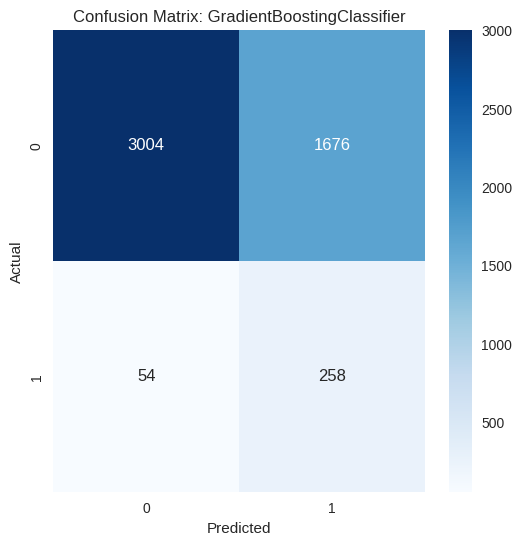

In [271]:
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, model_GB.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=model_GB.classes_, 
                    yticklabels=model_GB.classes_)
plt.title(f"Confusion Matrix: GradientBoostingClassifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Кривая ROC AUC

ROC-кривая — это график, отображающий зависимость True Positive Rate (TPR) от False Positive Rate (FPR) при варьировании порога классификации.

#### Оси ROC-кривой:
- По оси X: False Positive Rate (FPR)  
$$
  FPR = \frac{FP}{FP + TN}
$$
- По оси Y: True Positive Rate (TPR), он же Recall  
$$ 
  TPR = \frac{TP}{TP + FN}
$$

#### AUC (Area Under Curve)

AUC — это площадь под ROC-кривой. Она показывает, насколько хорошо модель умеет различать классы.

- AUC = 1.0 — идеальный классификатор.
- AUC = 0.5 — модель не лучше случайного угадывания.
- AUC < 0.5 — модель работает хуже случайного угадывания (например, перепутала классы).

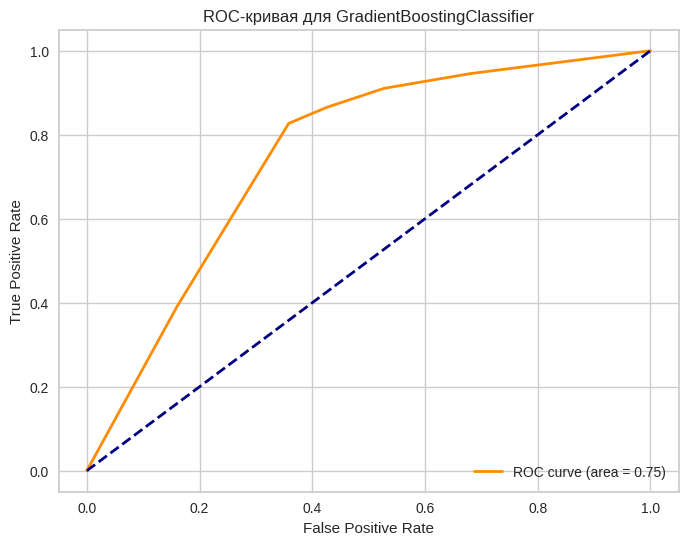

In [272]:
fpr, tpr, _ = roc_curve(y_test, model_GB.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
            
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая для GradientBoostingClassifier')
plt.legend(loc="lower right")
plt.show()

## Настройка гиперпараметров AdaBoostingClassifier

In [273]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [274]:
AdaBoostClassifier().get_params()

{'algorithm': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [ ]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 1, 5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    base_estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1.0, log=True)

    model = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Лучшие параметры:")
print(study.best_params)
print(f"Лучшая точность (accuracy): {study.best_value:.4f}")

[I 2025-04-11 23:30:58,450] A new study created in memory with name: no-name-116695bf-5ff8-49e9-afea-d2c229151df6
[I 2025-04-11 23:32:00,299] Trial 0 finished with value: 0.888711196275031 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'n_estimators': 291, 'learning_rate': 0.010956640098268508}. Best is trial 0 with value: 0.888711196275031.
[I 2025-04-11 23:32:28,848] Trial 1 finished with value: 0.8627318042673283 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 10, 'n_estimators': 133, 'learning_rate': 0.005267103061972716}. Best is trial 0 with value: 0.888711196275031.
[I 2025-04-11 23:33:27,852] Trial 2 finished with value: 0.8953580551980332 and parameters: {'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 10, 'n_estimators': 282, 'learning_rate': 0.017056904238883695}. Best is trial 2 with value: 0.8953580551980332.
[I 2025-04-11 23:33:40,928] Trial 3 finished with value: 0.7584040098153121 and parameters:

Лучшие параметры:
{'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'n_estimators': 276, 'learning_rate': 0.3519507426551877}
Лучшая точность (accuracy): 0.9148


In [276]:
study.best_params

{'max_depth': 5,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'n_estimators': 276,
 'learning_rate': 0.3519507426551877}

## Посмотрим на результат

In [277]:
%time
model_Ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=study.best_params["max_depth"],
                                                                min_samples_split=study.best_params["min_samples_split"],
                                                                min_samples_leaf=study.best_params["min_samples_leaf"]),
                                                                n_estimators=study.best_params["n_estimators"],
                                                                learning_rate=study.best_params["learning_rate"]).fit(X_train, y_train)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.86 μs


In [278]:
print("Scores:")
get_scores(model_Ada, X_test, y_test)

Scores:
accuracy_score: 0.8114983974358975
precision_score: 0.17743589743589744
recall_score: 0.5544871794871795
f1_score: 0.26884226884226886
ROC_AUC: 0.691559829059829


## Анализ модели

### Кривые переобучения

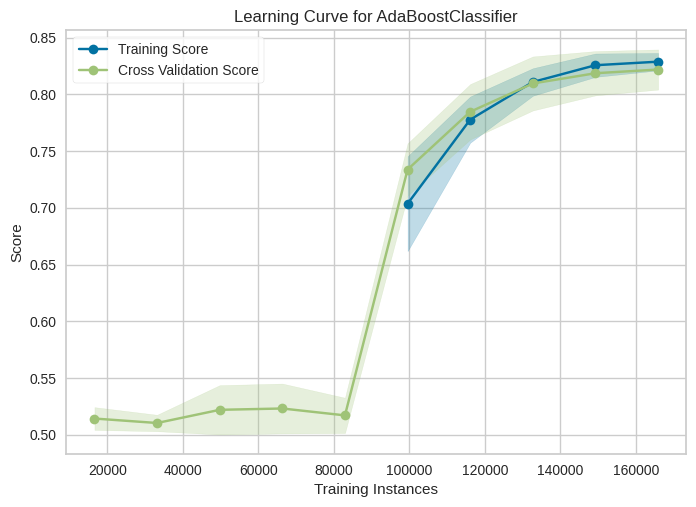

In [279]:
metric = make_scorer(roc_auc_score, response_method="predict")
visualizer = LearningCurve(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=study.best_params["max_depth"],
                                                                min_samples_split=study.best_params["min_samples_split"],
                                                                min_samples_leaf=study.best_params["min_samples_leaf"]),
                                                                n_estimators=study.best_params["n_estimators"],
                                                                learning_rate=study.best_params["learning_rate"]), scoring=metric, cv=StratifiedKFold(n_splits=3), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_train, y_train).show()

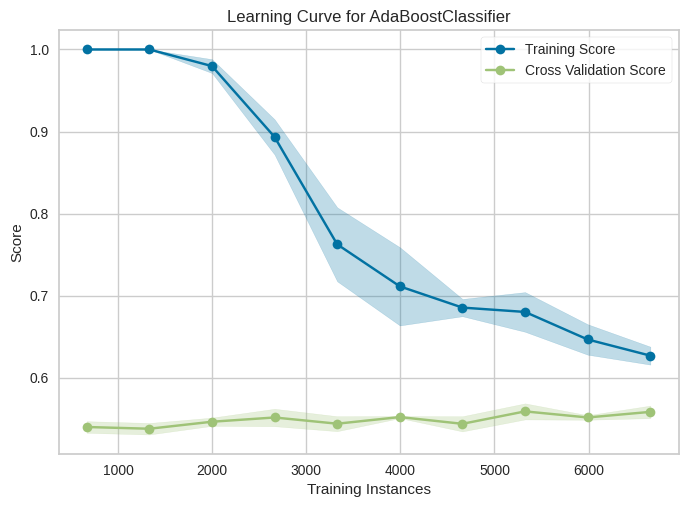

In [280]:
metric = make_scorer(roc_auc_score, response_method="predict")
visualizer = LearningCurve(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=study.best_params["max_depth"],
                                                                min_samples_split=study.best_params["min_samples_split"],
                                                                min_samples_leaf=study.best_params["min_samples_leaf"]),
                                                                n_estimators=study.best_params["n_estimators"],
                                                                learning_rate=study.best_params["learning_rate"]), scoring=metric, cv=StratifiedKFold(n_splits=3), train_sizes=np.linspace(0.1, 1.0, 10)
).fit(X_calibrate, y_calibrate).show()

### Матрица несоответский (Confusion Matrix)

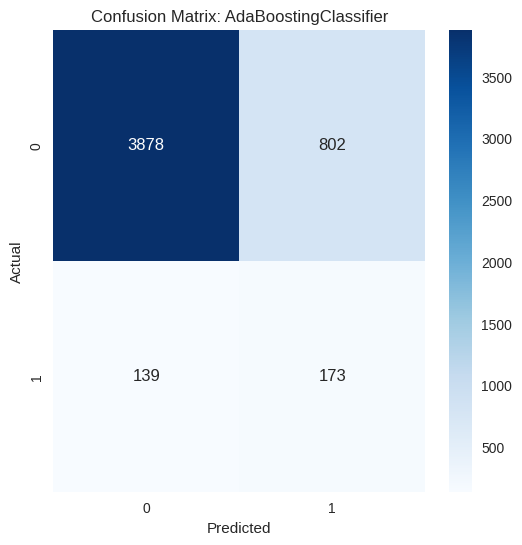

In [281]:
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, model_Ada.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=model_Ada.classes_, 
                    yticklabels=model_Ada.classes_)
plt.title(f"Confusion Matrix: AdaBoostingClassifier")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Кривая ROC AUC

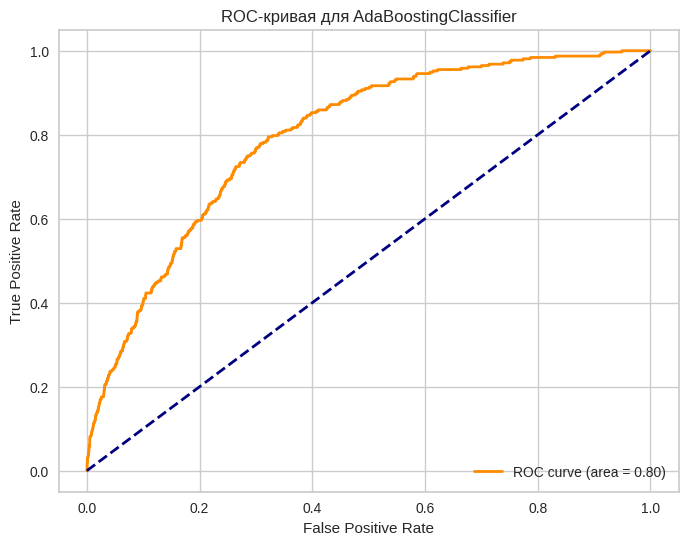

In [282]:
fpr, tpr, _ = roc_curve(y_test, model_Ada.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
            
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая для AdaBoostingClassifier')
plt.legend(loc="lower right")
plt.show()

## Заключение

В данной работе разобран принцип работы, реализована и применена для решения практической задачи байесовской оптимизации для настройки гипперпараметров моделей машиннного обучения, решающих задачу кредитного скорринга. Изучен и реализован гауссовский процесс с гладким гауссовым ядром, функции приобретения. Указана и показана существенность главной проблемы всех ядерных методов машинного обучения - проклятие размерности. Как было показано, при увеличении размерности пространства ядерные функции расстояния всё хуже отражают это самое расстояние, из-за чего разница между двумя объектами становится незначительной. 

Проведён анализ [данных](https://www.kaggle.com/competitions/GiveMeSomeCredit/overview), устранены и пропуски, выявлены наиболее информативные и обучен ряд моделей. После оптимизации и анализа эффетвиности видно, что лучшей моделью в рамках решаемой задачи и имеющихся данных является оптимизированный AdaBoosting с базовой модель DecisionTree. Оценка производилась по метрике ROC AUC (0.8), так как дизбаланс классов не позволяет доверять таким метрикам как precision и recall. Этот же дизбаланс классов является "узким горлышком" всего решения и для улучшения результатов модели предпочтительно собрать больше данных угнетенного класса. 
